In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tensorflow.python.keras.datasets import mnist
import torchvision.models as models
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
#import cv2
#from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
import math
from PIL import Image
from scipy import misc
import pylab as plt
%matplotlib inline
import numpy as np
import skimage.transform
import pandas
import scipy.misc

import tensorflow 

from tensorflow import keras
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.layers import Input, Dense, ZeroPadding2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.utils import np_utils

gpu_options = tensorflow.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1)

def download_image(path):
    return misc.imread(path, mode='L')
def show_image(image):
    imgplot = plt.imshow(image, cmap='gray')
    plt.show()
    
def prepare_image(image, c=128):
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if (image[i, j] < c):
                image[i, j] = 0
            else:
                image[i, j] = 1
            
size = 28                
def resize (img):
    im = Image.fromarray(img)
    im.thumbnail((size, size), Image.ANTIALIAS)
    im = np.array(im).astype('float32')
    return np.expand_dims(np.pad(im, (((size - im.shape[0]) // 2, (size - im.shape[0] + 1) // 2), ((size - im.shape[1]) // 2, (size - im.shape[1] + 1) // 2)), 'constant', constant_values=255), axis = -1)
       
    
def load_data(path):
    trainAll = pandas.read_csv(path + "/emnist-letters-train.csv")
    trainLetters = trainAll.values[:,1:785]
    trainLabels = trainAll.values[:,0:1]
    testAll = pandas.read_csv(path + "/emnist-letters-test.csv")
    testLetters = testAll.values[:,1:785]
    testLabels = testAll.values[:,0:1]
    
    X_train = np.zeros(trainLetters.shape)
    for i in range(trainLetters.shape[0]):
        X_train[i] = (trainLetters[i].reshape(28, 28).T / 1).reshape(28 * 28)
    y_train = trainAll.values[:,0:1] - 1

    X_test = np.zeros(testLetters.shape)
    for i in range(testLetters.shape[0]):
        X_test[i] = (testLetters[i].reshape(28, 28).T / 1).reshape(28 * 28)
    y_test = testAll.values[:,0:1] - 1
    return X_train, y_train, X_test, y_test

/Users/yack_domnicky/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
all_letters_X_train, all_letters_y_train, all_letters_X_test, all_letters_y_test = load_data("/Users/yack_domnicky/EMNIST_data")

In [3]:
def make_dict(data):
    return {a: 0 for a in data}
height, width, depth = 28, 28, 1
count = np.zeros((26))
for Y in all_letters_y_train:
    count[Y] += 1
class_num_train = int(min(count) * (4/5))
class_num_test = int(min(count)) - class_num_train
alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
letters = 'XYAB'
letters_num = len(letters)
counter_train = make_dict(letters)
counter_test = make_dict(letters)
last_train = 0
last_test = 0
letters_X_train = np.zeros((letters_num * class_num_train, height * width))
letters_y_train = np.zeros((letters_num * class_num_train))
letters_X_test = np.zeros((letters_num * class_num_test, height * width))
letters_y_test = np.zeros((letters_num * class_num_test))
for i in range(all_letters_X_train.shape[0]):
    letter = alphabet[all_letters_y_train[i][0]]
    if (letter in letters):
        if counter_train[letter] < class_num_train:
            letters_X_train[last_train] = all_letters_X_train[i]
            letters_y_train[last_train] = int(letters.find(letter))
            last_train += 1
            counter_train[letter] += 1
        elif counter_test[letter] < class_num_test:
            letters_X_test[last_test] = all_letters_X_train[i]
            letters_y_test[last_test] = int(letters.find(letter))
            last_test += 1
            counter_test[letter] += 1

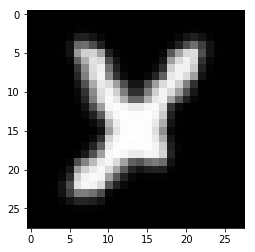

0.0


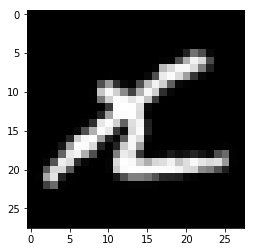

0.0


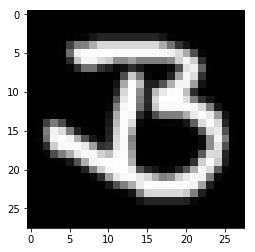

3.0


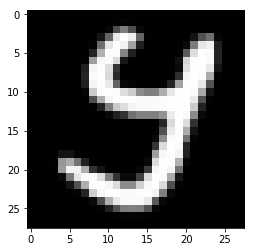

1.0


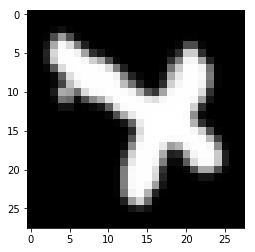

0.0


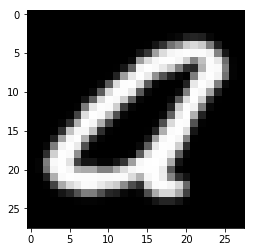

2.0


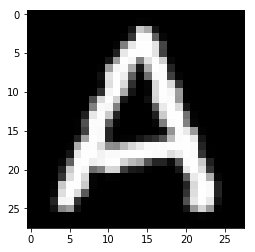

2.0


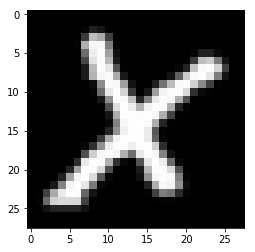

0.0


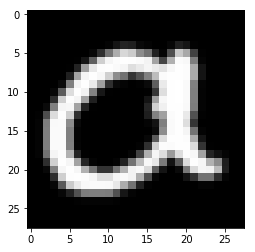

2.0


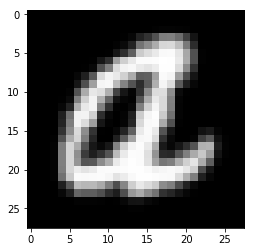

2.0


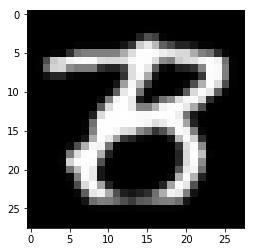

3.0


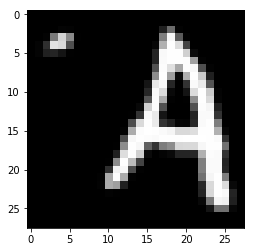

2.0


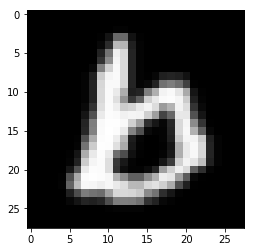

3.0


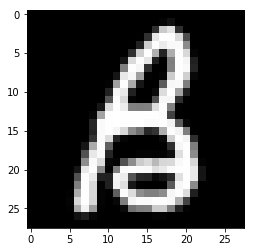

3.0


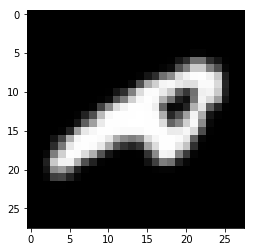

2.0


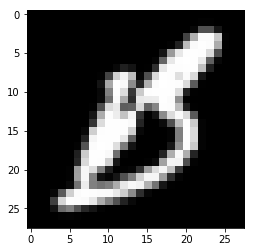

3.0


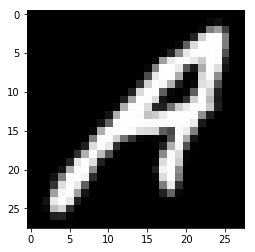

2.0


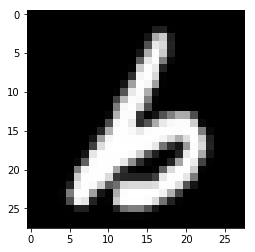

3.0


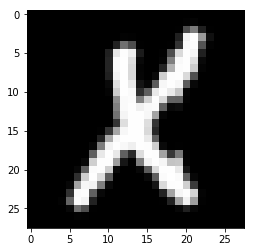

0.0


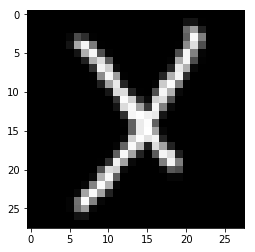

0.0


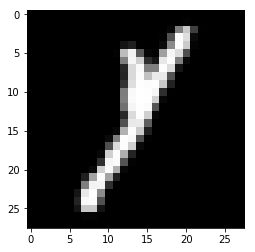

1.0


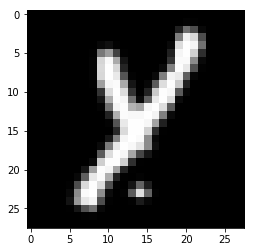

1.0


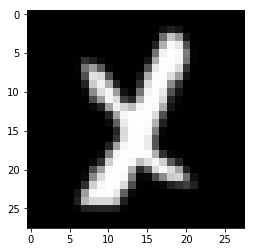

0.0


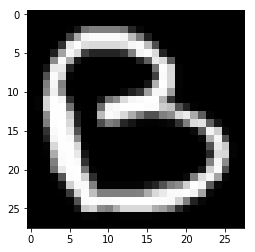

3.0


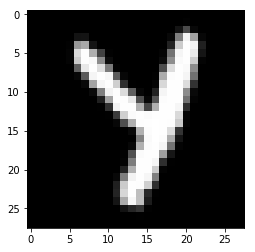

1.0


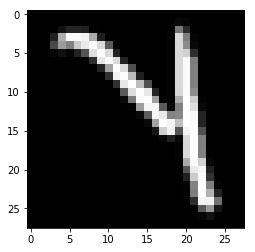

1.0


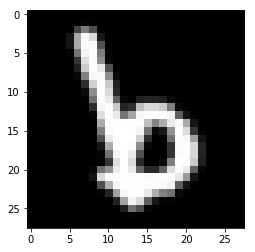

3.0


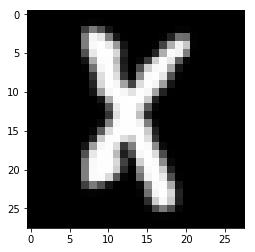

0.0


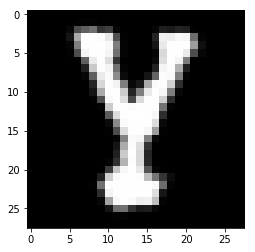

1.0


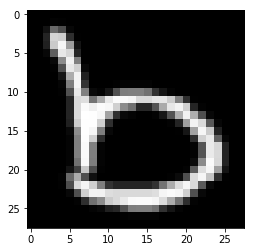

3.0


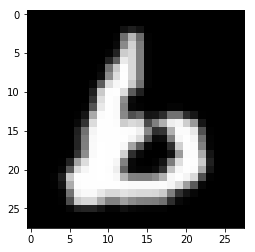

3.0


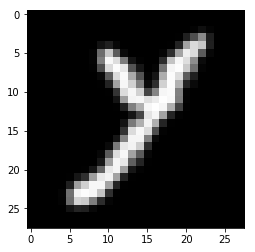

1.0


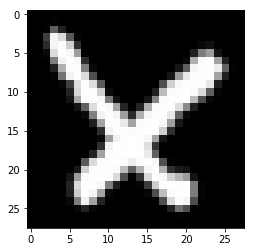

0.0


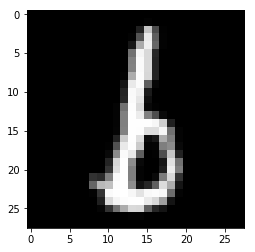

3.0


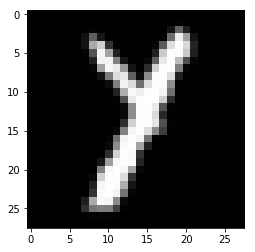

1.0


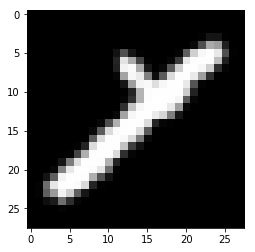

1.0


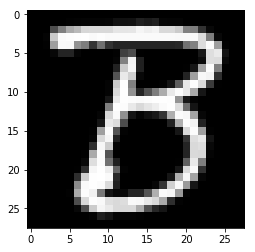

3.0


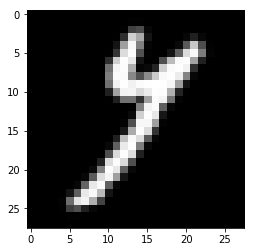

1.0


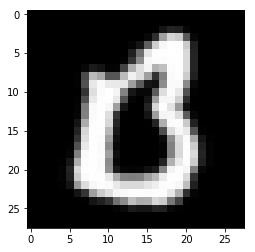

3.0


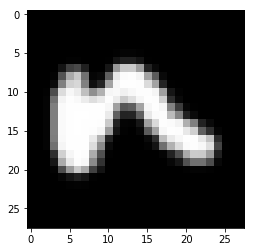

2.0


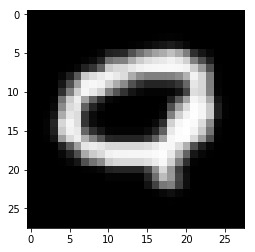

2.0


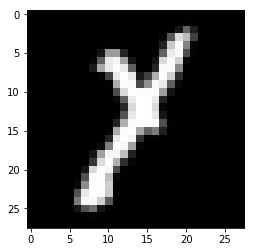

1.0


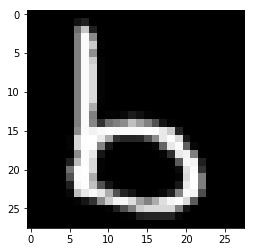

3.0


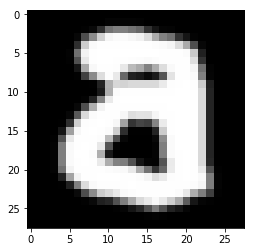

2.0


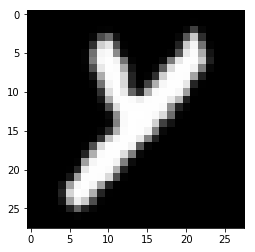

1.0


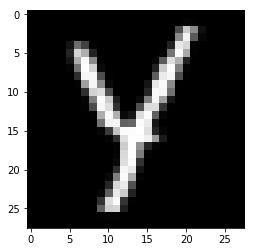

1.0


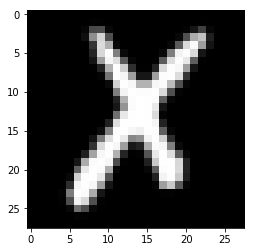

0.0


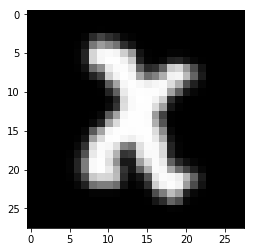

0.0


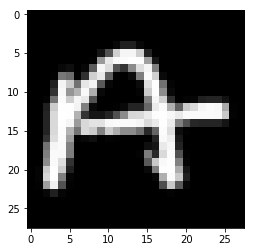

2.0


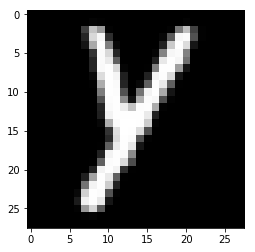

1.0


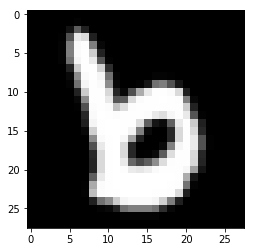

3.0


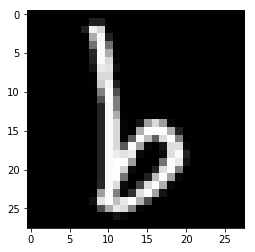

3.0


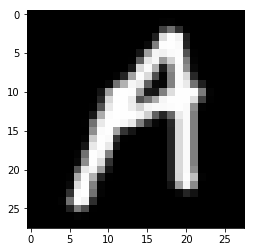

2.0


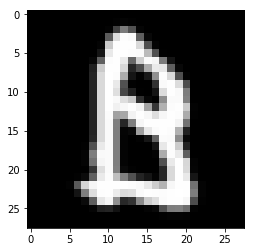

3.0


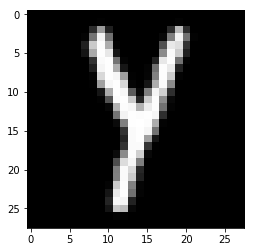

1.0


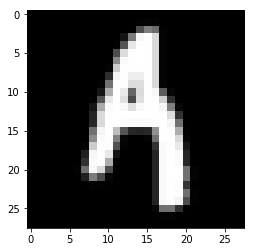

2.0


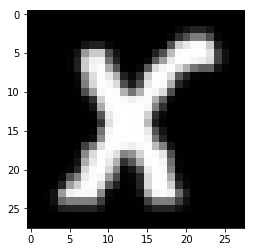

0.0


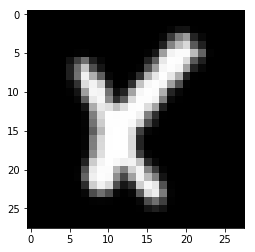

0.0


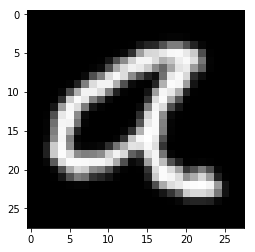

2.0


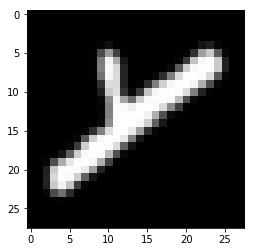

1.0


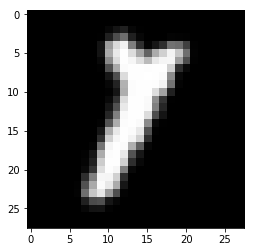

1.0


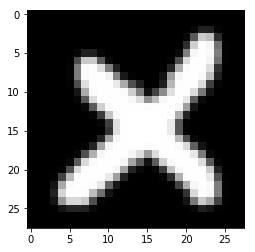

0.0


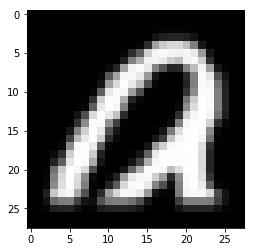

2.0


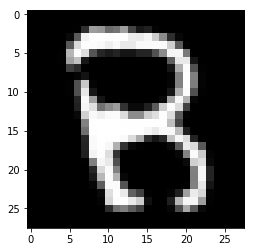

3.0


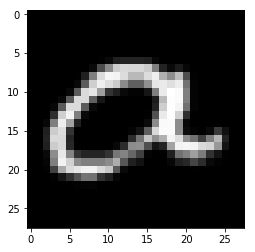

2.0


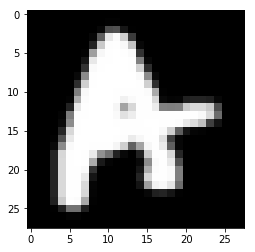

2.0


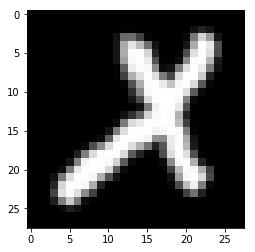

0.0


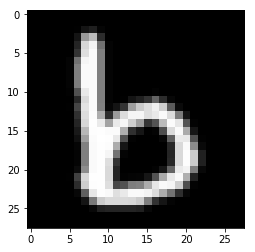

3.0


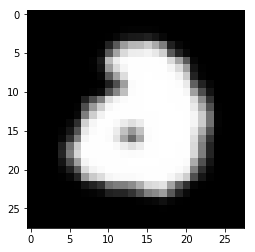

2.0


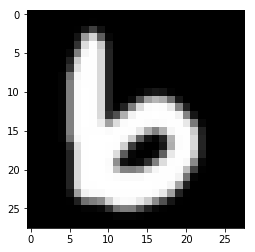

3.0


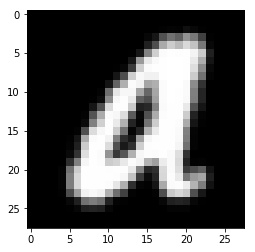

2.0


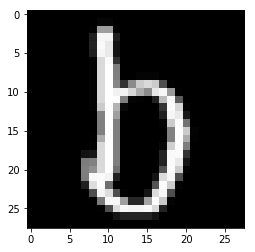

3.0


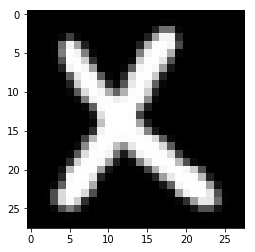

0.0


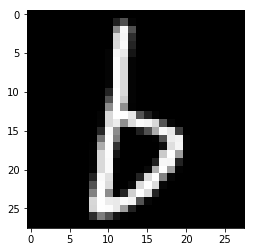

3.0


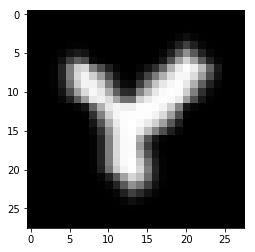

1.0


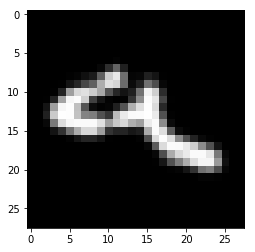

2.0


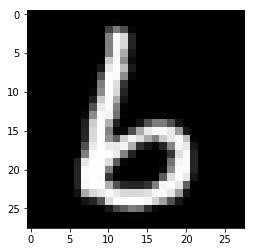

3.0


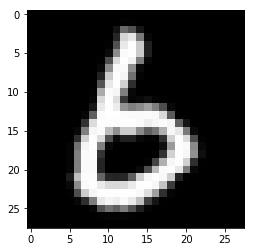

3.0


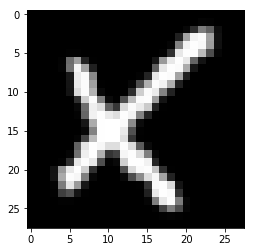

0.0


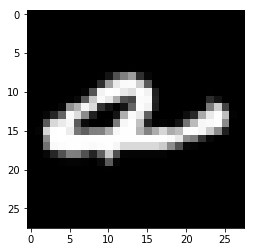

2.0


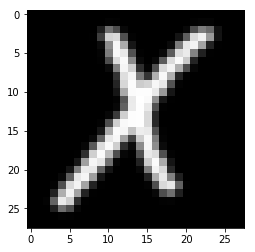

0.0


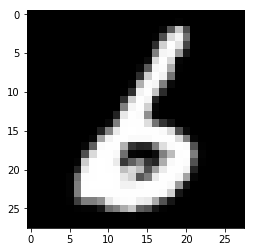

3.0


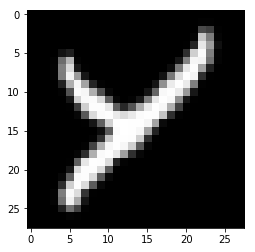

1.0


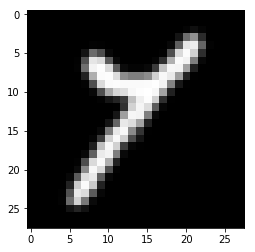

1.0


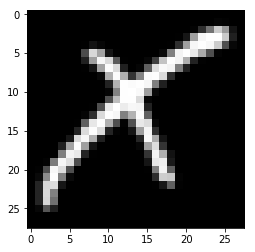

0.0


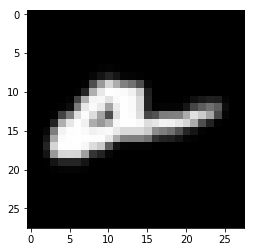

2.0


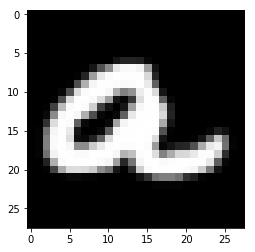

2.0


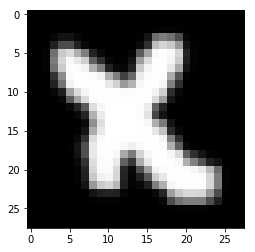

0.0


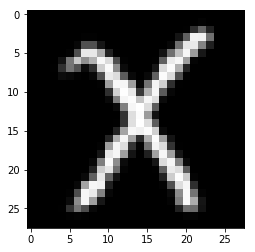

0.0


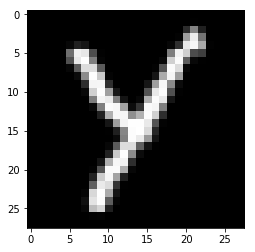

1.0


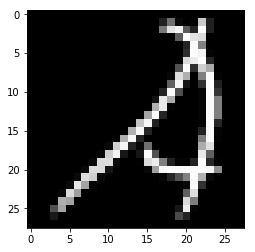

2.0


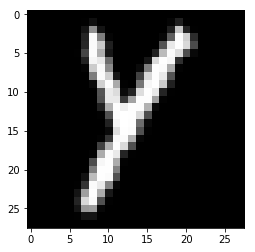

1.0


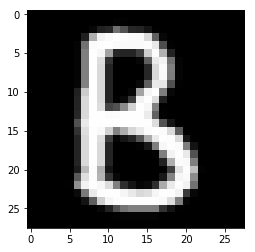

3.0


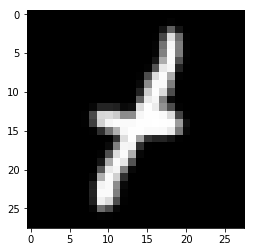

1.0


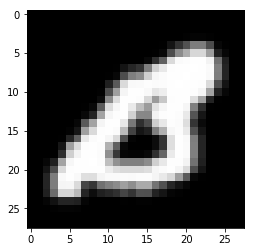

3.0


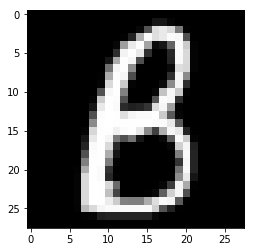

3.0


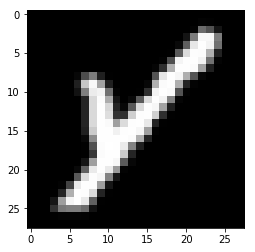

1.0


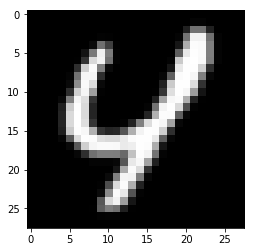

1.0


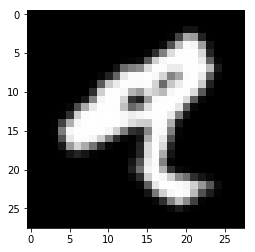

2.0


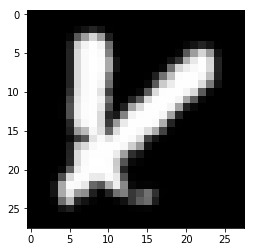

0.0


In [4]:
for i in range(100):
    show_image(letters_X_train[i].reshape((28, 28)))
    print(letters_y_train[i])

In [5]:
import random
random.seed()

tmp_train = list()
for i in range(len(letters_X_train)):
    tmp_train.append((letters_X_train[i], letters_y_train[i]))
tmp_test = list()
for i in range(len(letters_X_test)):
    tmp_test.append((letters_X_test[i], letters_y_test[i]))

for i in range(100):
    random.shuffle(tmp_train)
    random.shuffle(tmp_test)

for i in range(len(letters_X_train)):
    letters_X_train[i] = tmp_train[i][0]
    letters_y_train[i] = tmp_train[i][1]
    
for i in range(len(letters_X_test)):
    letters_X_test[i] = tmp_test[i][0]
    letters_y_test[i] = tmp_test[i][1]
 



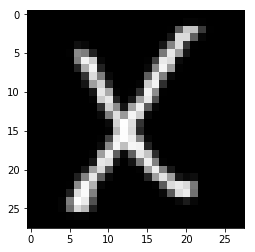

0.0


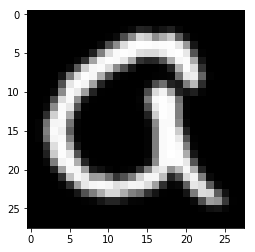

2.0


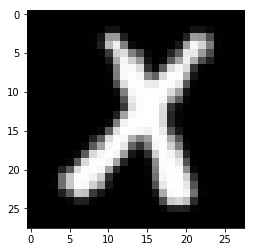

0.0


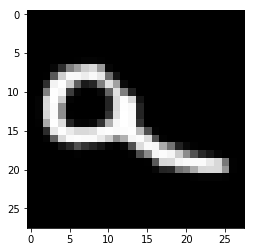

2.0


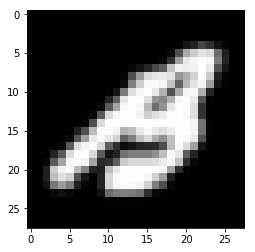

3.0


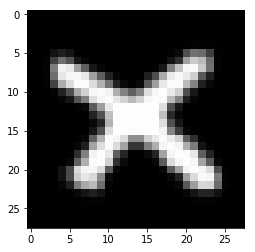

0.0


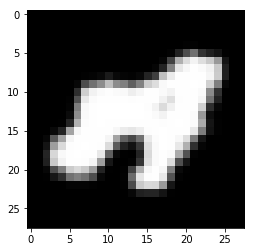

2.0


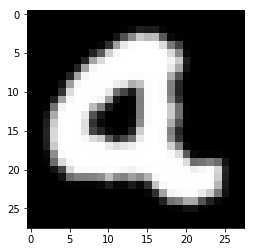

2.0


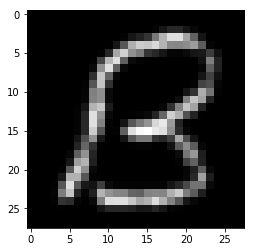

3.0


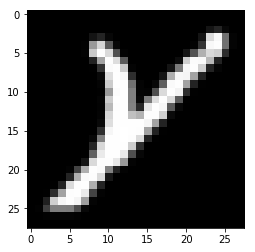

1.0


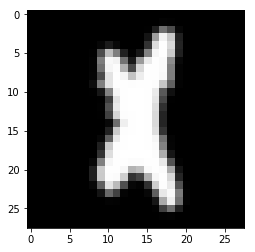

0.0


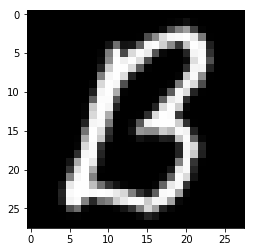

3.0


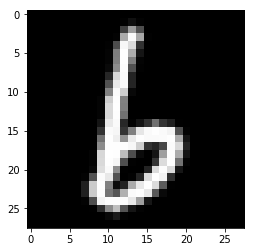

3.0


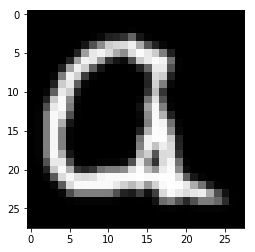

2.0


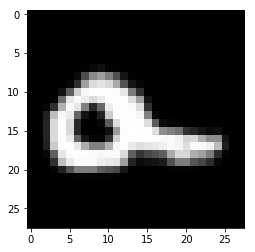

2.0


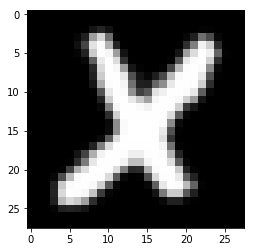

0.0


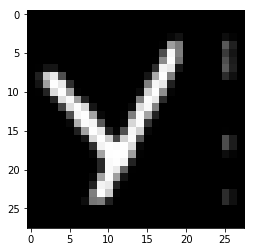

1.0


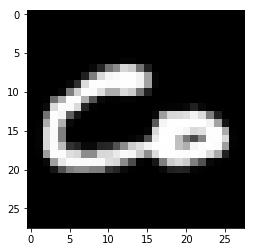

2.0


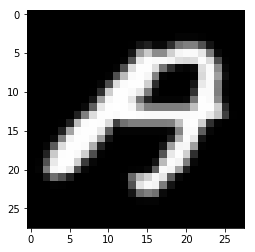

2.0


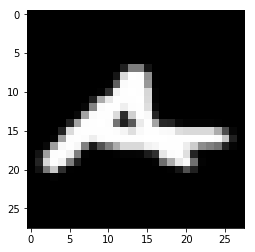

2.0


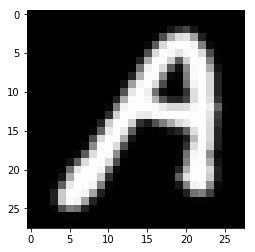

2.0


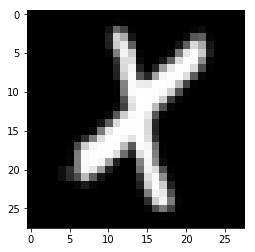

0.0


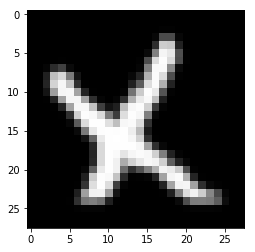

0.0


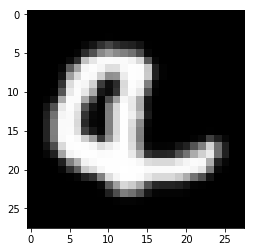

2.0


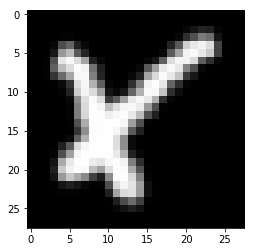

0.0


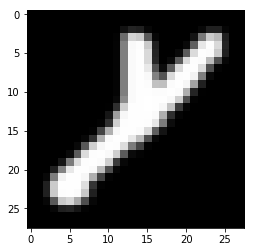

1.0


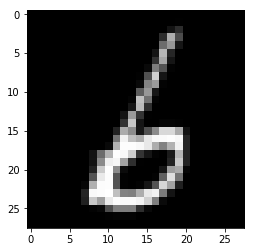

3.0


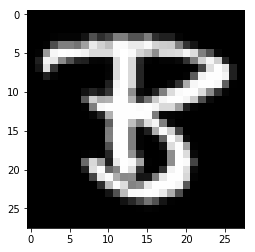

3.0


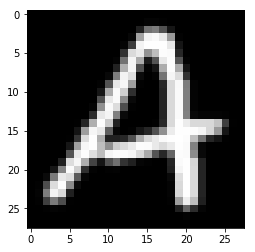

2.0


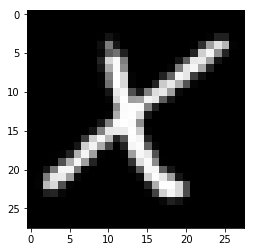

0.0


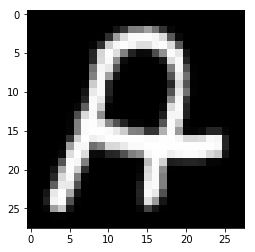

2.0


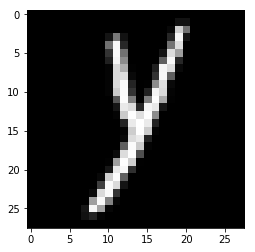

1.0


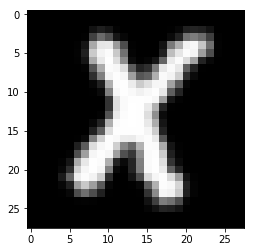

0.0


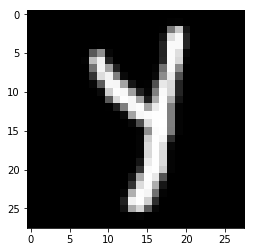

1.0


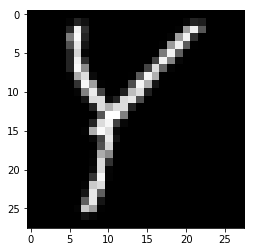

1.0


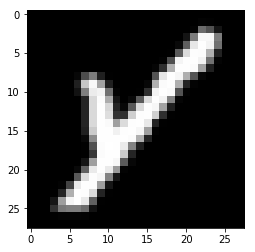

1.0


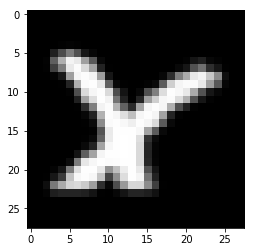

0.0


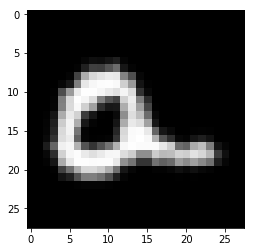

2.0


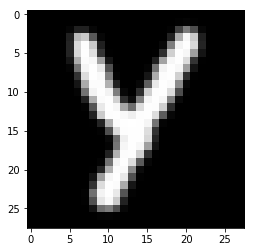

1.0


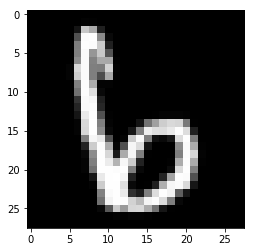

3.0


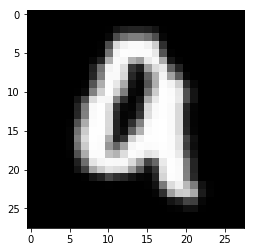

2.0


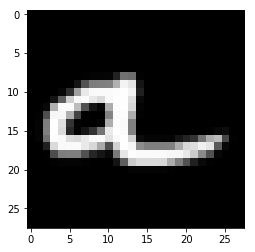

2.0


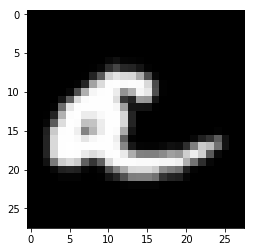

2.0


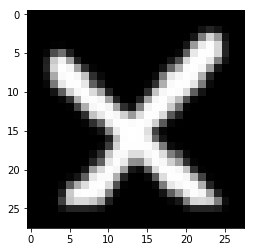

0.0


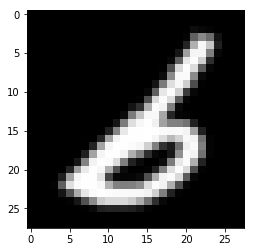

3.0


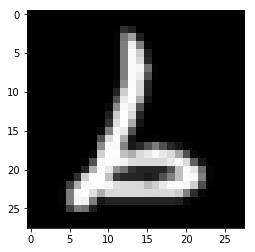

3.0


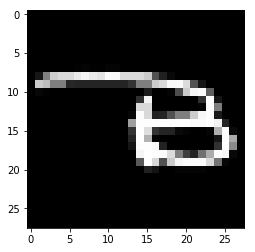

3.0


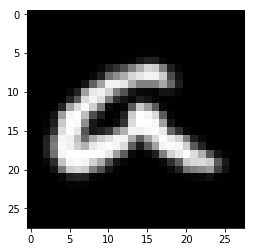

2.0


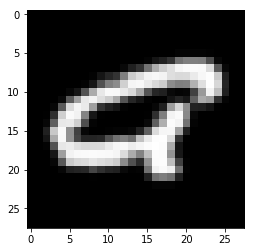

2.0


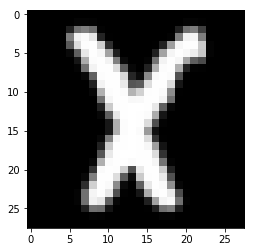

0.0


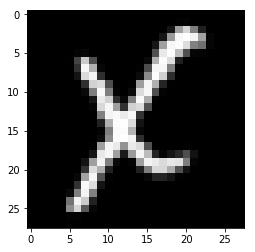

0.0


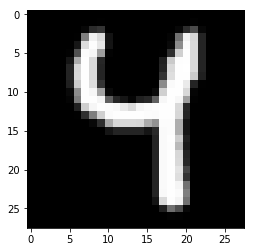

1.0


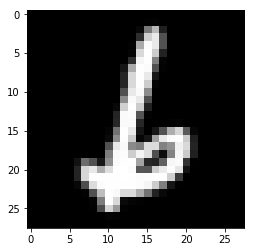

3.0


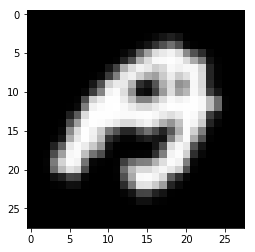

2.0


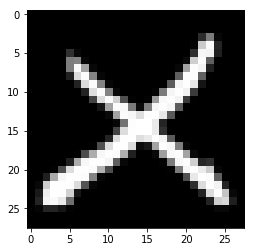

0.0


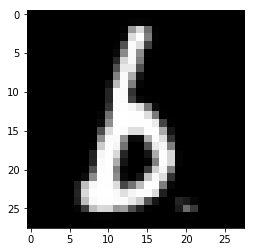

3.0


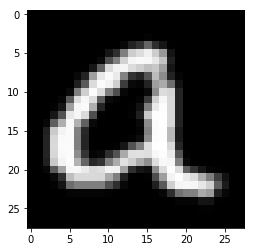

2.0


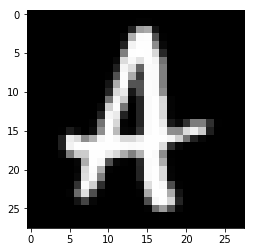

2.0


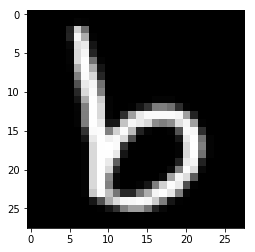

3.0


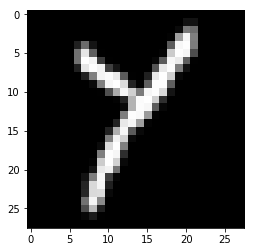

1.0


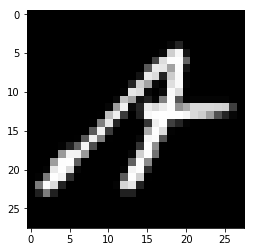

2.0


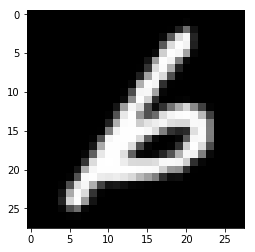

3.0


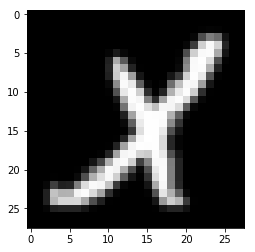

0.0


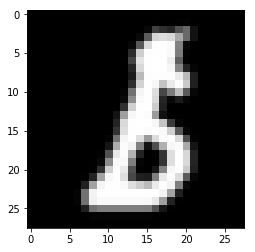

3.0


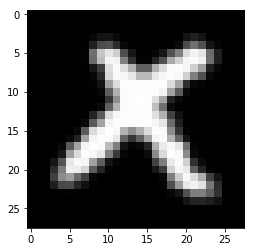

0.0


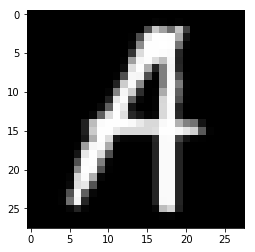

2.0


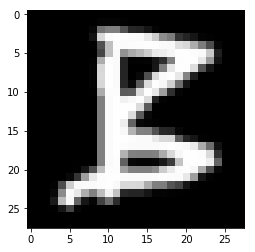

3.0


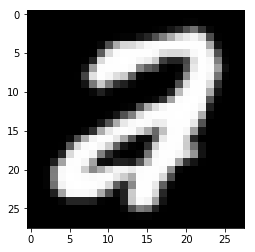

2.0


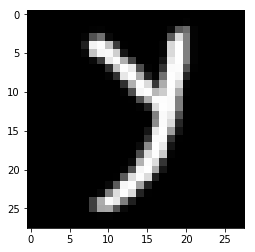

1.0


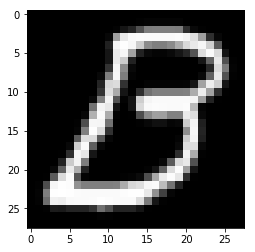

3.0


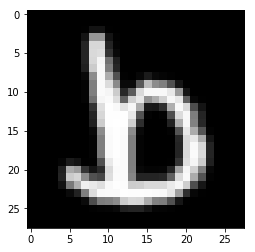

3.0


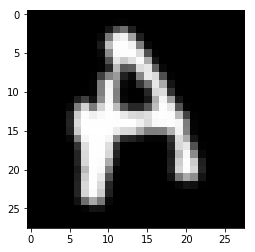

2.0


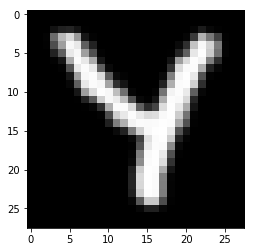

1.0


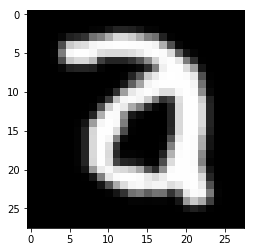

2.0


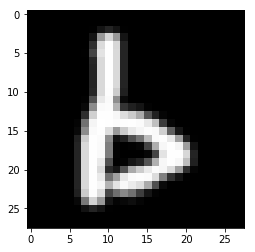

3.0


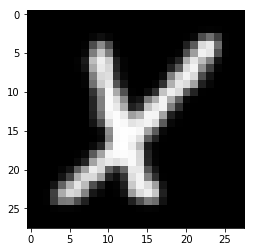

0.0


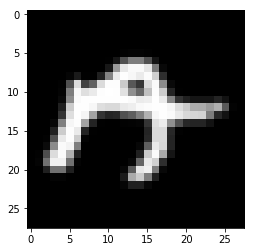

2.0


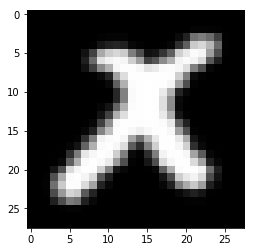

0.0


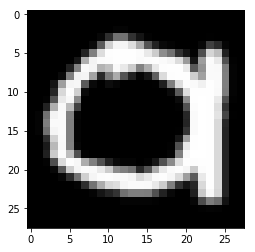

2.0


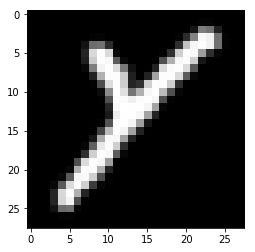

1.0


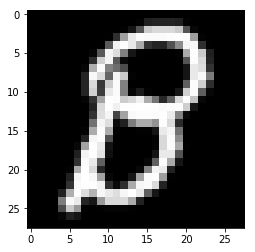

3.0


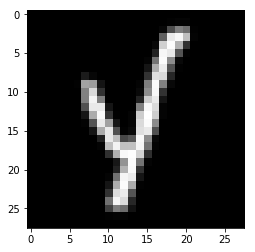

1.0


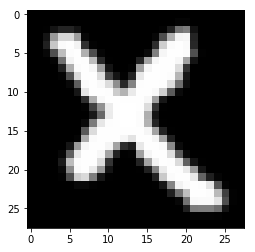

0.0


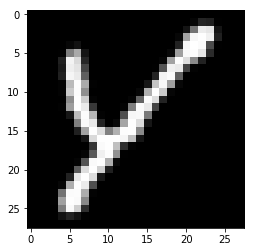

1.0


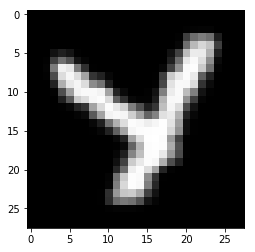

1.0


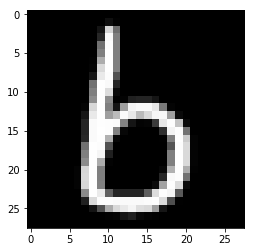

3.0


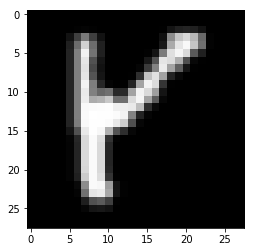

1.0


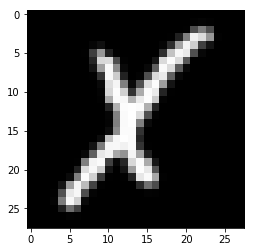

0.0


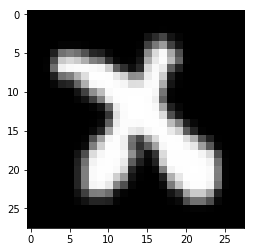

0.0


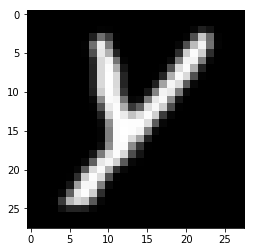

1.0


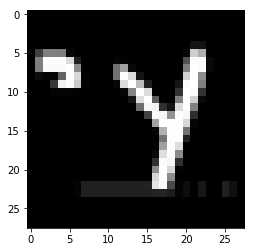

1.0


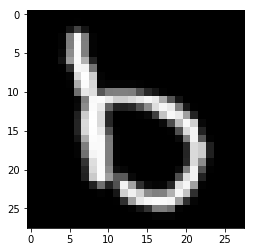

3.0


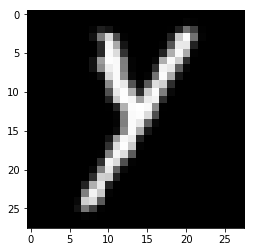

1.0


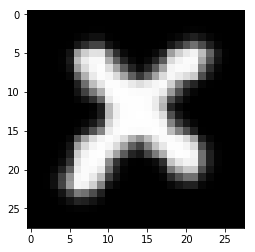

0.0


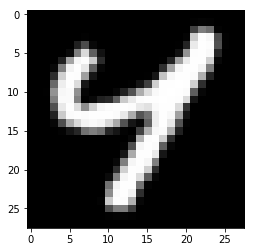

1.0


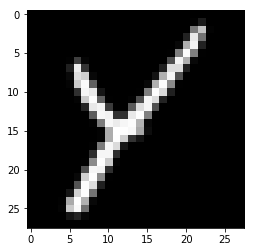

1.0


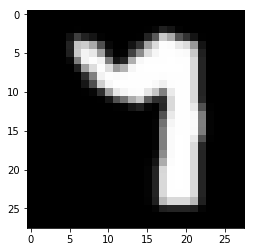

1.0


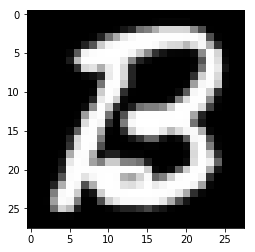

3.0


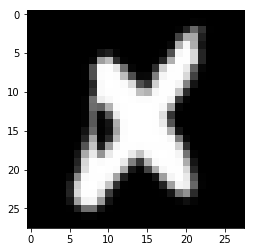

0.0


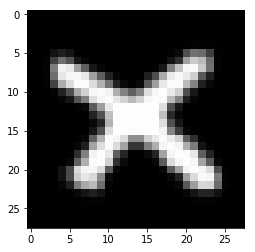

2.0


In [6]:
for i in range(100):
    show_image(letters_X_train[i].reshape((28, 28)))
    print(letters_y_train[i])

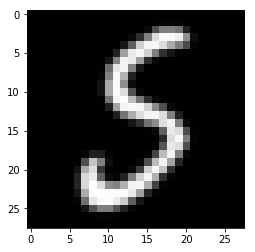

4.0


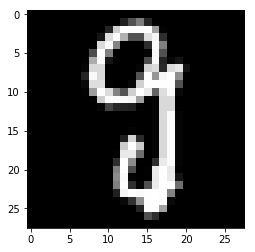

7.0


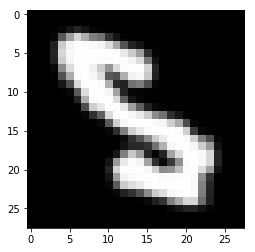

4.0


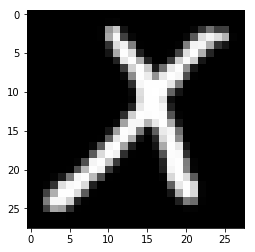

2.0


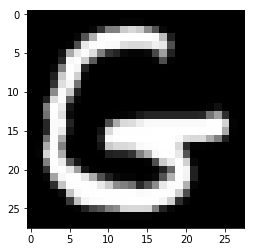

7.0


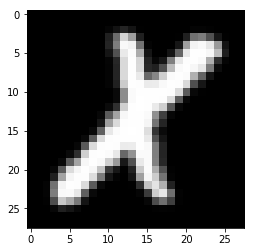

2.0


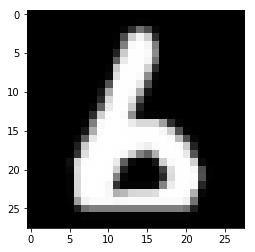

1.0


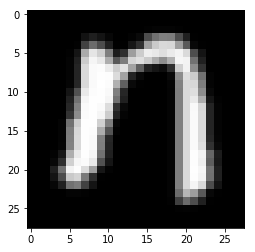

5.0


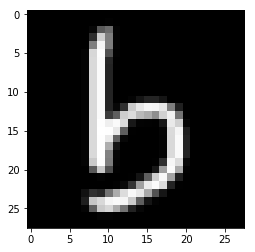

1.0


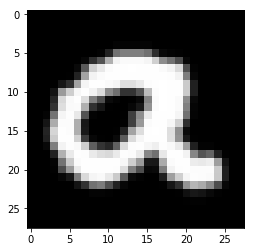

0.0


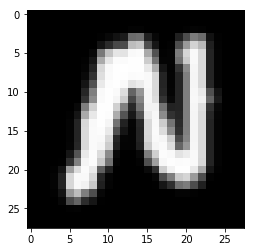

5.0


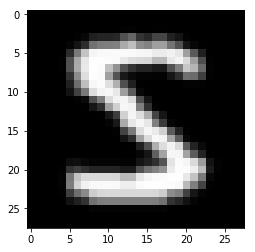

4.0


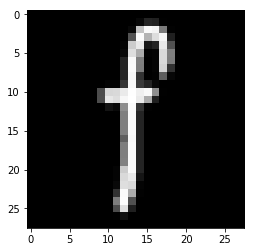

6.0


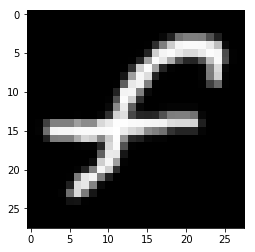

6.0


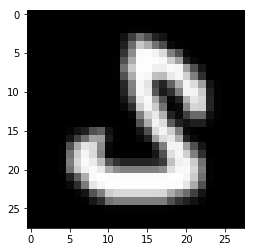

4.0


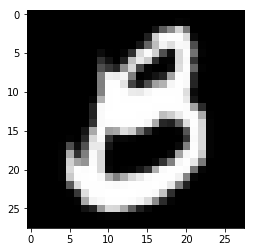

1.0


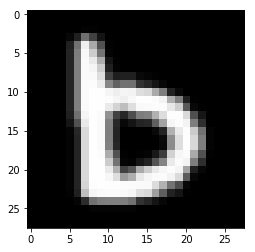

1.0


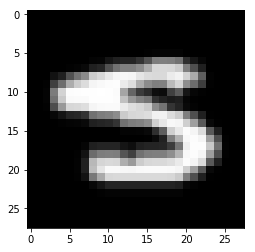

4.0


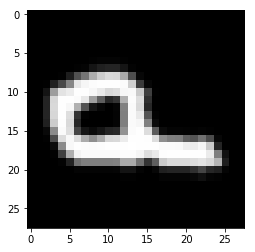

0.0


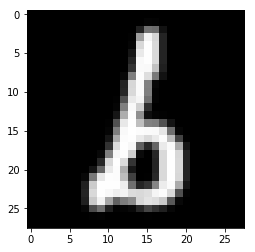

1.0


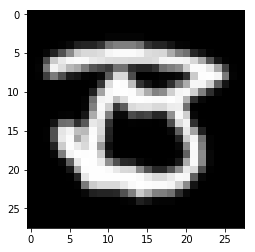

1.0


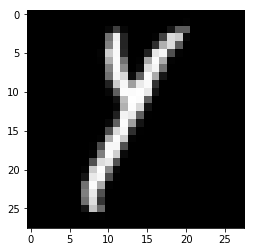

3.0


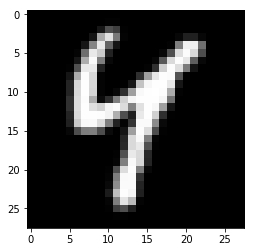

3.0


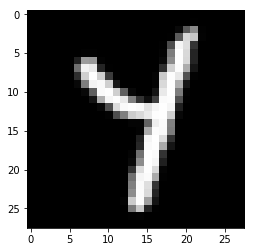

3.0


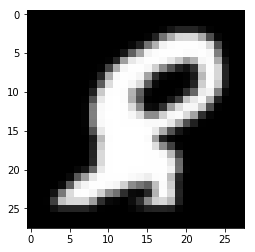

7.0


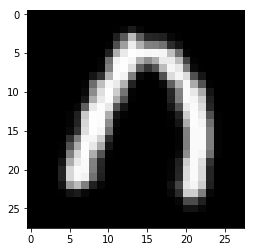

5.0


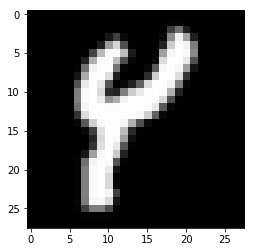

3.0


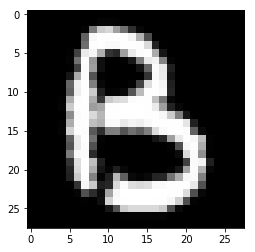

1.0


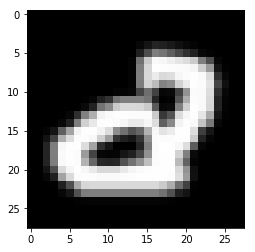

0.0


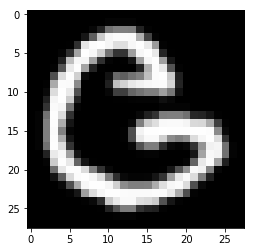

7.0


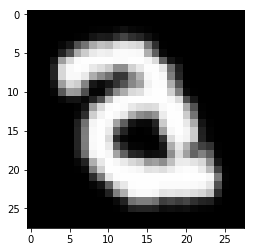

0.0


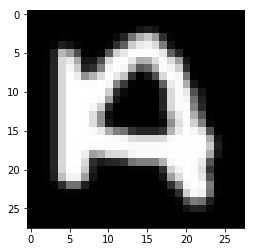

0.0


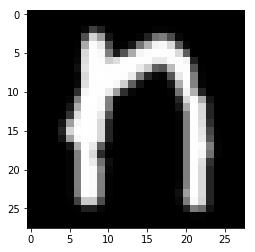

5.0


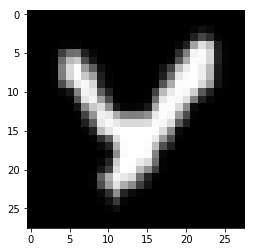

3.0


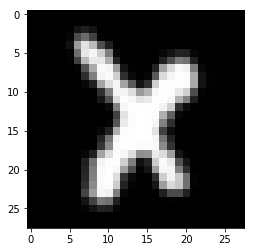

2.0


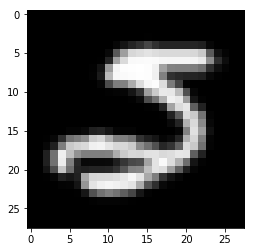

4.0


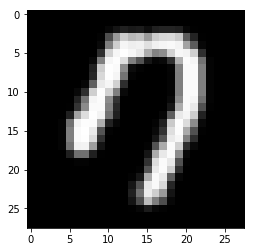

5.0


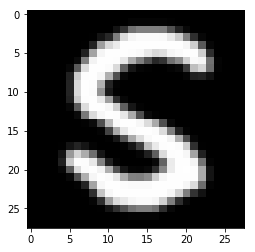

4.0


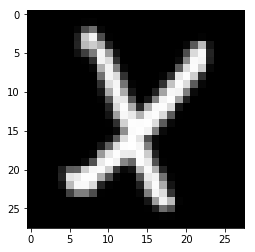

2.0


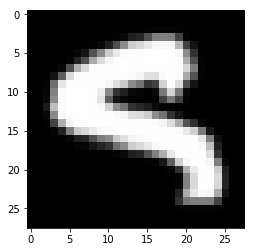

4.0


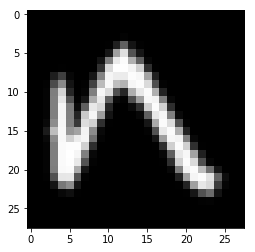

5.0


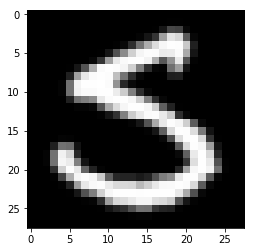

4.0


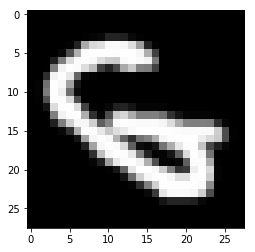

7.0


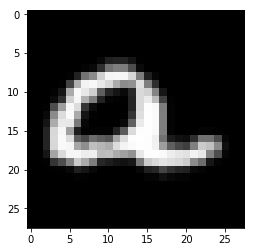

0.0


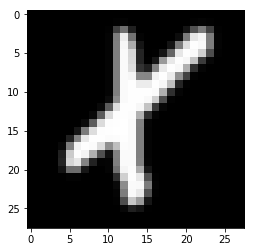

2.0


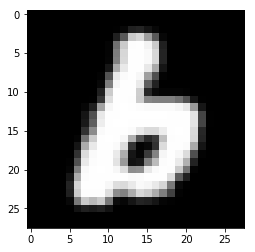

1.0


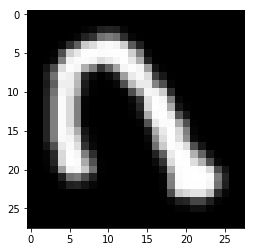

5.0


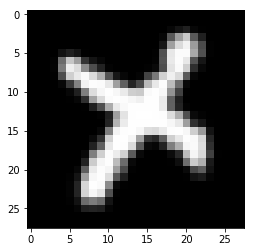

2.0


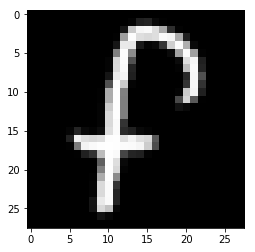

6.0


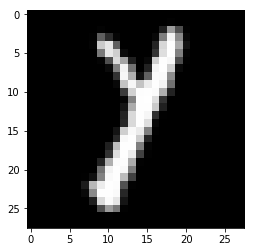

3.0


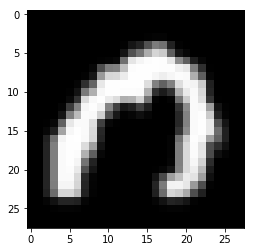

5.0


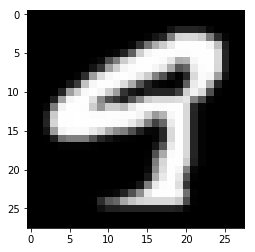

7.0


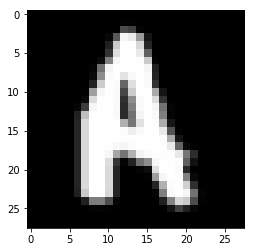

0.0


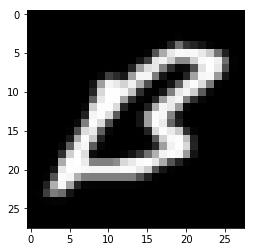

1.0


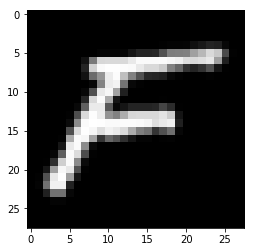

6.0


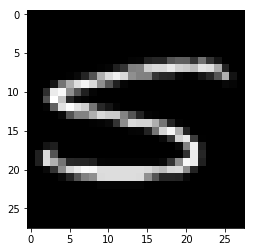

4.0


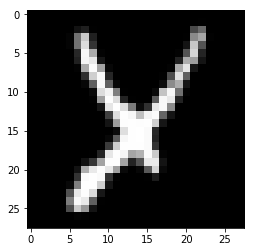

2.0


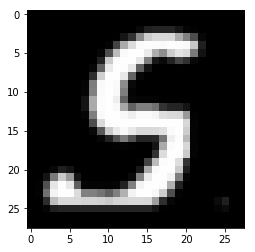

4.0


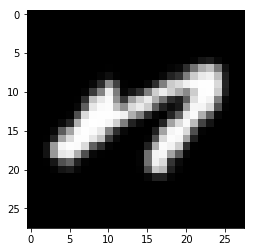

5.0


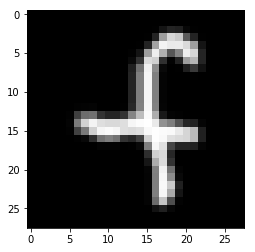

6.0


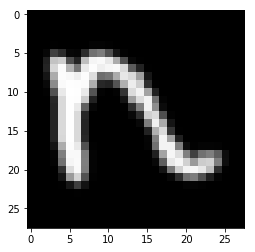

5.0


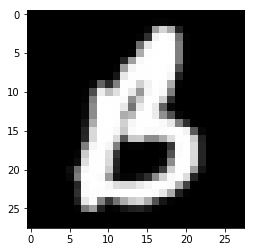

1.0


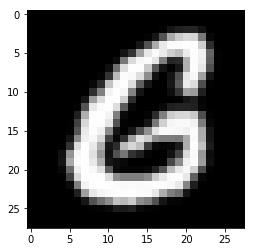

7.0


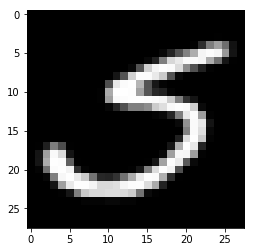

4.0


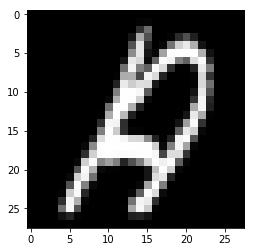

0.0


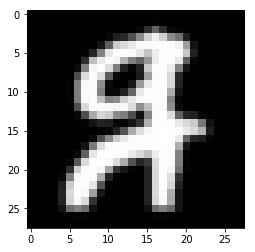

7.0


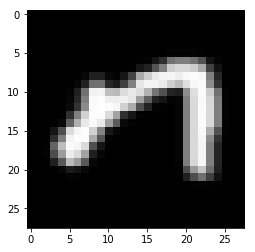

5.0


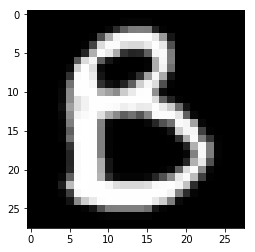

1.0


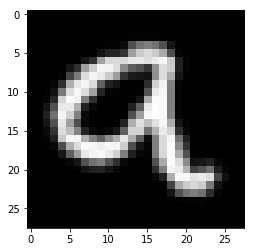

0.0


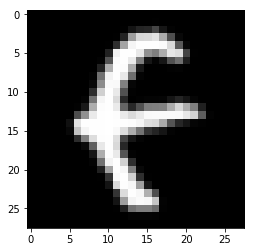

6.0


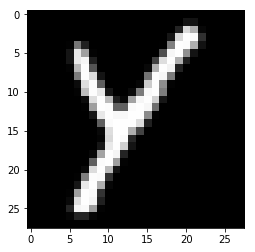

3.0


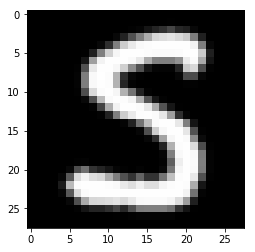

4.0


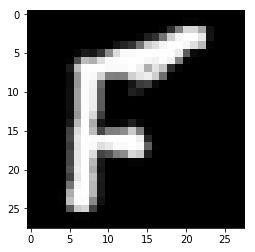

6.0


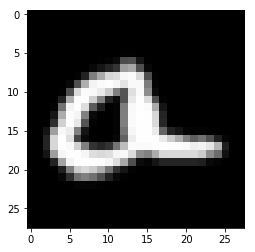

0.0


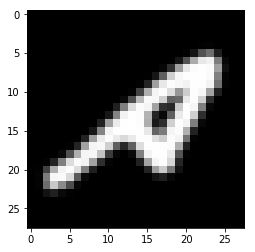

0.0


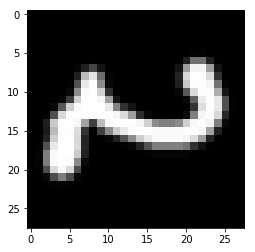

5.0


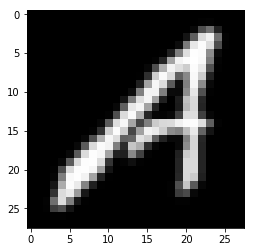

0.0


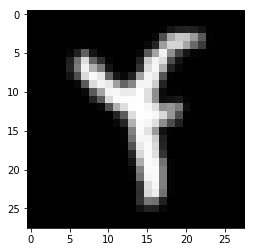

3.0


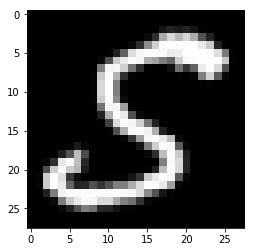

4.0


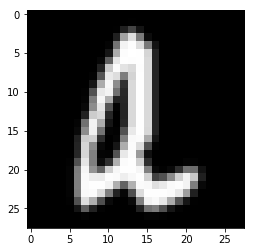

0.0


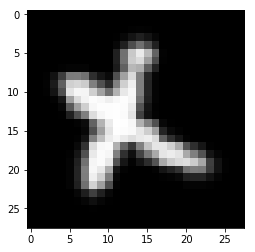

2.0


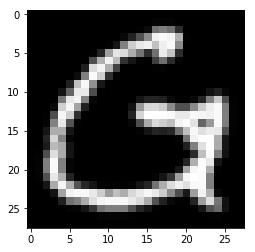

7.0


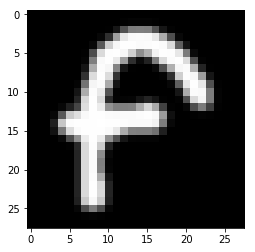

6.0


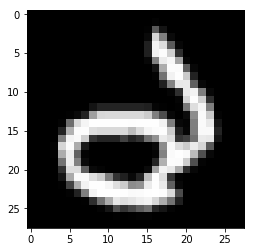

0.0


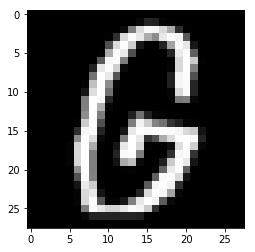

7.0


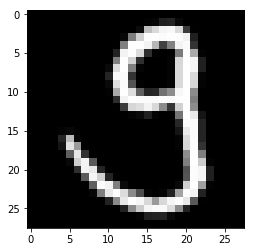

7.0


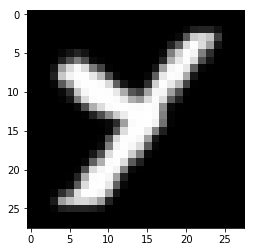

3.0


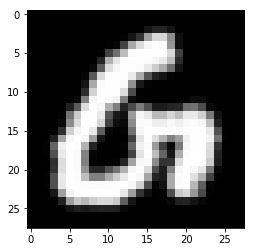

7.0


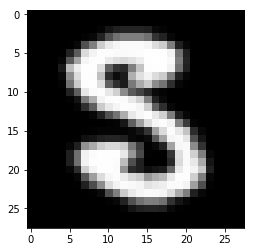

4.0


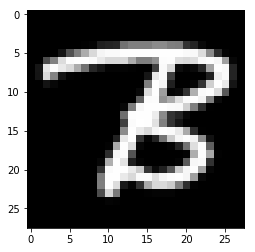

1.0


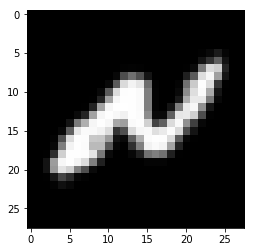

5.0


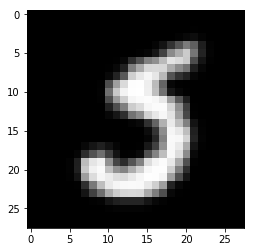

4.0


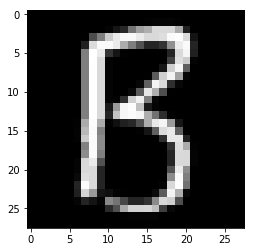

1.0


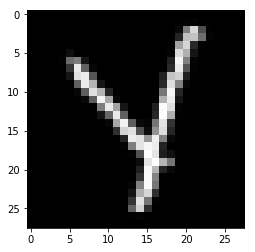

3.0


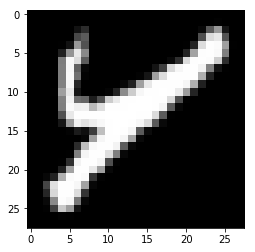

3.0


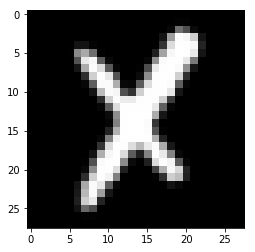

2.0


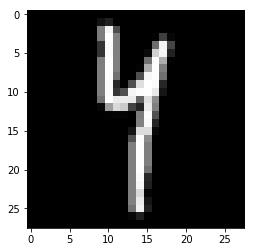

3.0


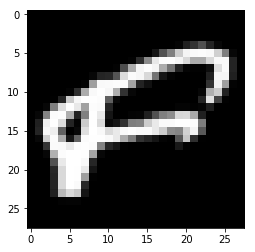

6.0


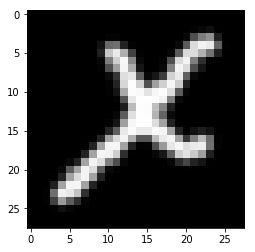

2.0


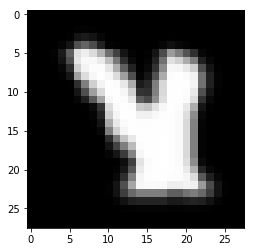

2.0


In [6]:
for i in range(100):
    show_image(letters_X_test[i].reshape((28, 28)))
    print(letters_y_test[i])

In [4]:
batch_size = 128
num_epochs = 20
hidden_size = 512

num_train = letters_num * class_num_train
num_test = letters_num * class_num_test

height, width, depth = 28, 28, 1
num_classes = letters_num


X_train, y_train, X_test, y_test = letters_X_train, letters_y_train, letters_X_test, letters_y_test

X_train = X_train.reshape(num_train, height * width)
X_test = X_test.reshape(num_test, height * width)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train
X_test = X_test

X_train = X_train.reshape((X_train.shape[0], height, width, 1))
X_test = X_test.reshape((X_test.shape[0], height, width, 1))

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

inp = Input(shape=(height, width, 1))
out = inp
out = ZeroPadding2D()(out)
out = Conv2D(kernel_size=(3, 3), filters=16)(out)
out = LeakyReLU(alpha=0.1)(out)
out = MaxPooling2D()(out)
out = ZeroPadding2D()(out)
out = Conv2D(kernel_size=(3, 3), filters=32)(out)
out = LeakyReLU(alpha=0.1)(out)
out = MaxPooling2D()(out)
out = Flatten()(out)
out = Dense(512)(out)
out = LeakyReLU(alpha=0.1)(out)
out = Dense(num_classes, activation='softmax')(out)

model = Model(inp, out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
model.summary()

model.fit(X_train, Y_train, 
          batch_size=batch_size, nb_epoch=num_epochs, verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
__________

[0.054258820666973746, 0.986627043090639]

In [6]:
import h5py
model.save('Symbols_Fraiming/4LettersModel.h5')

In [5]:
(all_numbers_X_train, all_numbers_y_train), (all_numbers_X_test, all_numbers_y_test) = mnist.load_data()
all_numbers_X_train = all_numbers_X_train.reshape(len(all_numbers_X_train), height * width)
all_numbers_X_test = all_numbers_X_test.reshape(len(all_numbers_X_test), height * width)

In [6]:
numbers = [0, 1, 2, 3]#, 4, 5, 6, 7, 8, 9]
numbers_num = len(numbers)
counter_train = make_dict(numbers)
numbers_X_train = np.zeros((numbers_num * class_num_train, height * width))
numbers_y_train = np.zeros((numbers_num * class_num_train))
last = 0
for i in range(len(all_numbers_X_train)):
    if (all_numbers_y_train[i] > 3):
        continue
    if counter_train[all_numbers_y_train[i]] < class_num_train:
        numbers_X_train[last], numbers_y_train[last] = all_numbers_X_train[i], all_numbers_y_train[i]
        last += 1
        counter_train[all_numbers_y_train[i]] += 1
counter_test = make_dict(numbers)
numbers_X_test = np.zeros((numbers_num * class_num_test, height * width))
numbers_y_test = np.zeros((numbers_num * class_num_test))
last = 0
for i in range(len(all_numbers_X_test)):
    if (all_numbers_y_test[i] > 3):
        continue
    if counter_test[all_numbers_y_test[i]] < class_num_test:
        numbers_X_test[last], numbers_y_test[last] = all_numbers_X_test[i], all_numbers_y_test[i]
        last += 1
        counter_test[all_numbers_y_test[i]] += 1

In [7]:
X_train = np.zeros((len(numbers_X_train) + len(letters_X_train), height * width))
y_train = np.zeros((len(numbers_X_train) + len(letters_X_train)))
X_test = np.zeros((len(numbers_X_test) + len(letters_X_test), height * width))
y_test = np.zeros((len(numbers_X_test) + len(letters_X_test)))
for i in range(len(numbers_X_train) + len(letters_X_train)):
    if i < len(numbers_X_train):
        X_train[i], y_train[i] = numbers_X_train[i], numbers_y_train[i]
    else:
        X_train[i], y_train[i] = letters_X_train[i - len(numbers_X_train)], numbers_num + letters_y_train[i - len(numbers_X_train)]
        
count = np.zeros((40))
for Y in y_train:
    count[int(Y)] += 1
print(count)

for i in range(len(numbers_X_test) + len(letters_X_test)):
    if i < len(numbers_X_test):
        X_test[i], y_test[i] = numbers_X_test[i], numbers_y_test[i]
    else:
        X_test[i], y_test[i] = letters_X_test[i - len(numbers_X_test)], numbers_num + letters_y_test[i - len(numbers_X_test)]
        

[2692. 2692. 2692. 2692. 2692. 2692. 2692. 2692.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]


In [8]:
count = np.zeros((40))
for Y in y_test:
    count[int(Y)] += 1
print(count)

[673. 673. 673. 673. 673. 673. 673. 673.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]


In [9]:
import random
random.seed()
tmp_train = list()
tmp_test = list()
for i in range(len(X_train)):
    tmp_train.append((X_train[i], y_train[i]))
for i in range(len(X_test)):
    tmp_test.append((X_test[i], y_test[i]))

for i in range(100):
    random.shuffle(tmp_train)
    random.shuffle(tmp_test)

for i in range(len(X_train)):
    X_train[i] = tmp_train[i][0]
    y_train[i] = tmp_train[i][1]
for i in range(len(X_test)):
    X_test[i] = tmp_test[i][0]
    y_test[i] = tmp_test[i][1]

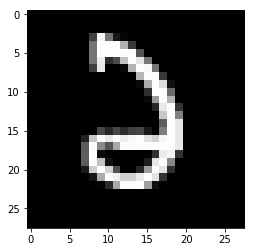

2


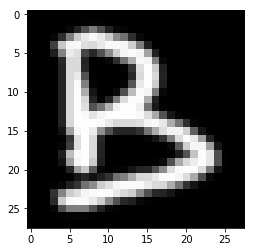

7


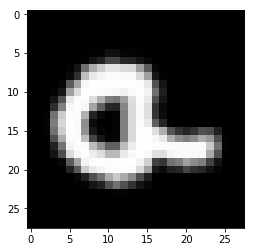

6


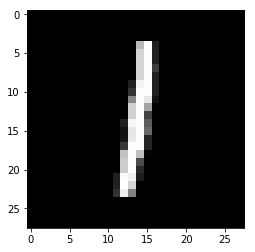

1


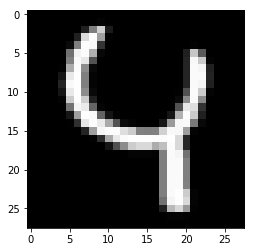

7


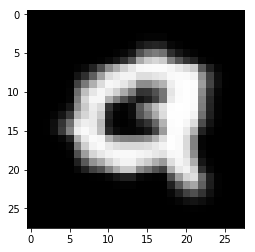

6


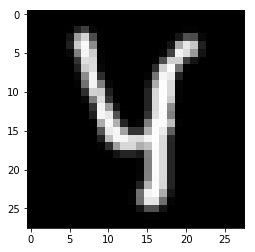

5


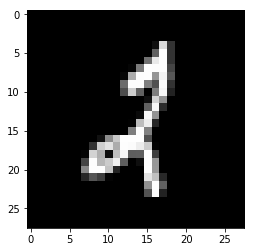

2


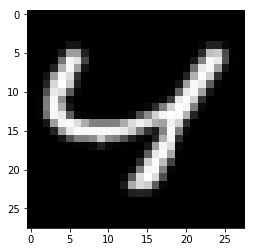

5


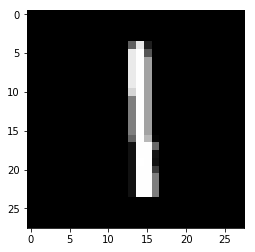

1


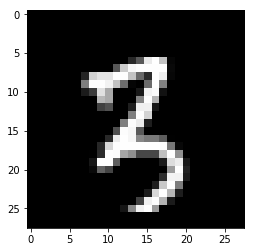

3


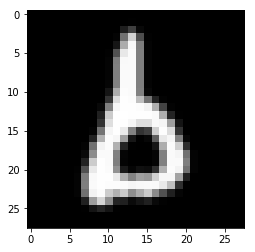

7


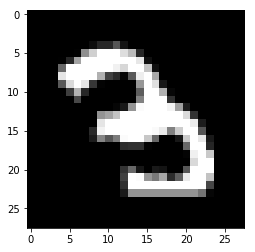

3


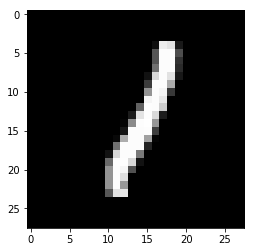

1


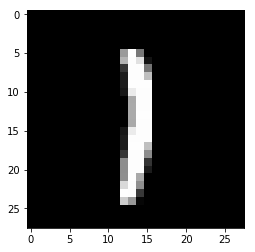

1


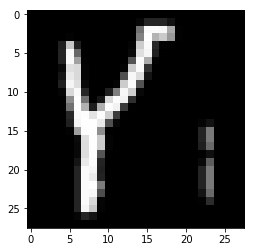

5


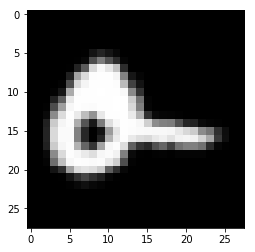

7


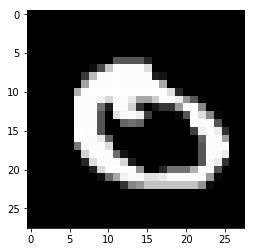

0


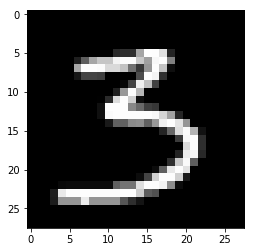

3


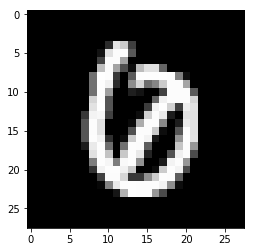

0


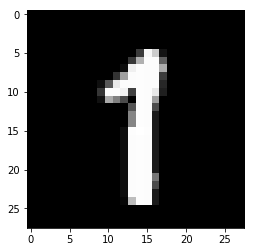

1


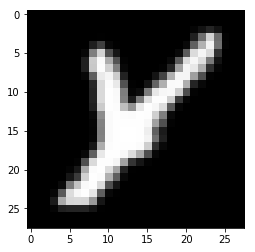

5


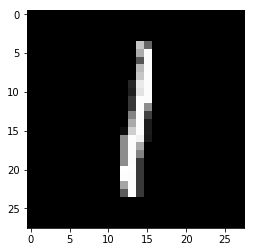

1


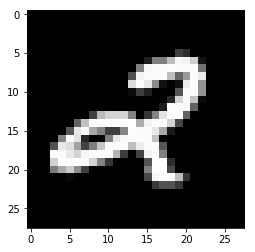

2


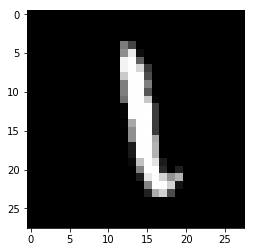

1


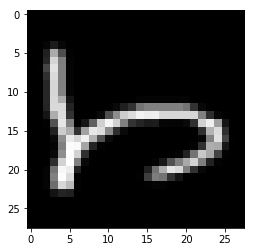

7


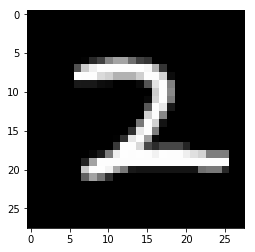

2


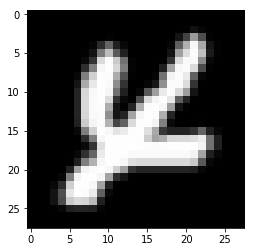

4


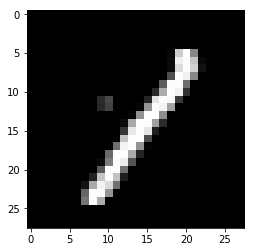

1


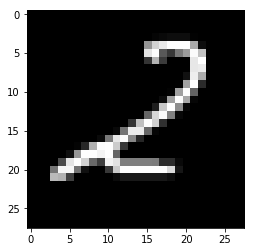

2


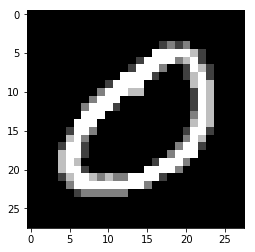

0


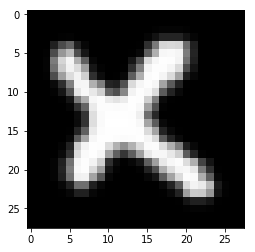

5


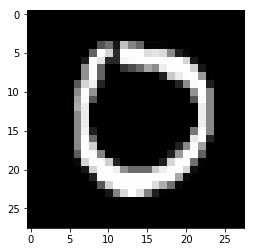

0


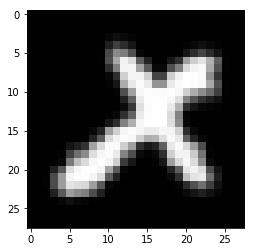

4


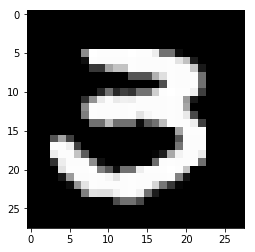

3


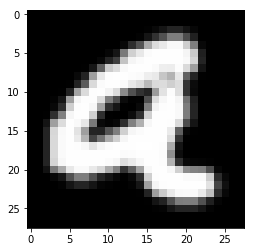

6


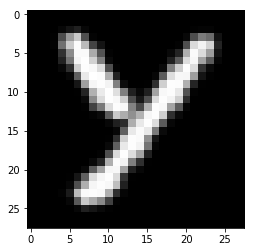

5


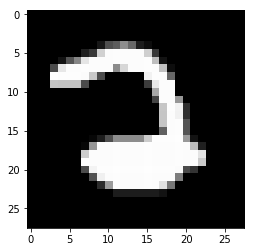

2


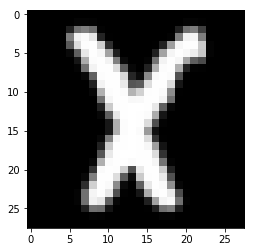

4


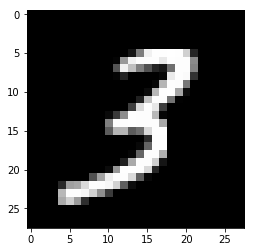

3


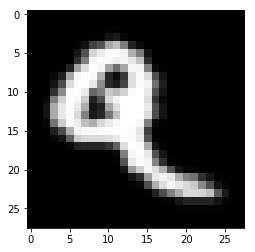

7


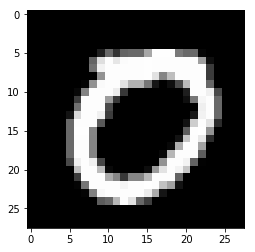

0


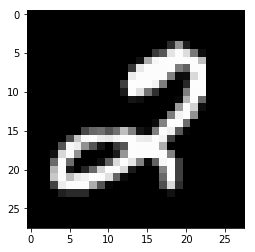

2


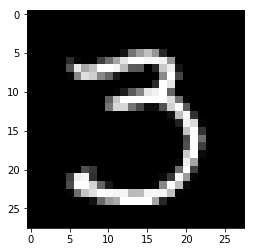

3


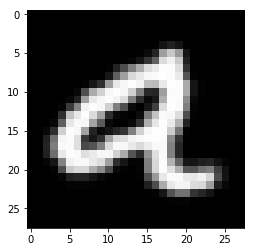

6


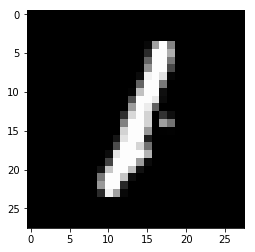

1


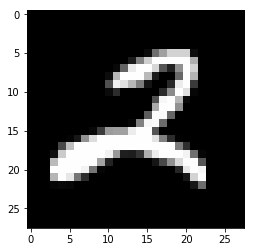

2


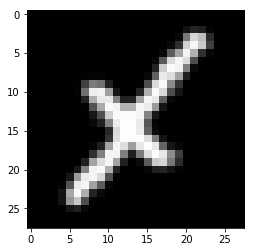

6


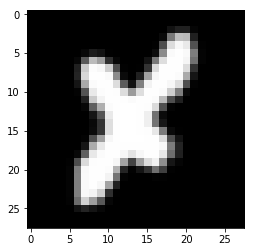

6


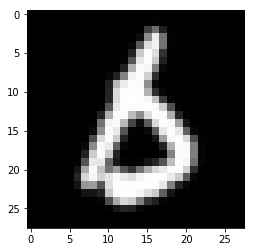

5


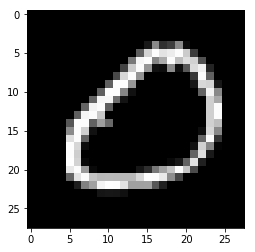

0


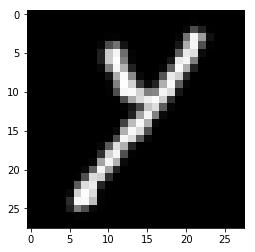

5


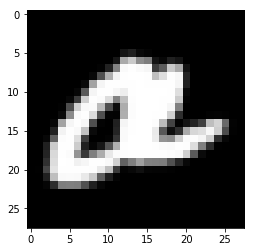

6


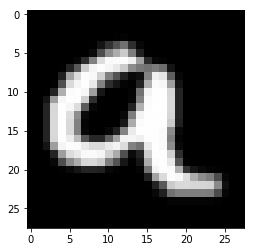

4


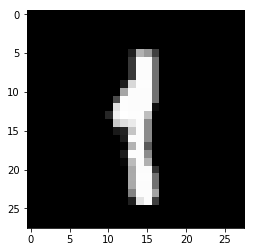

1


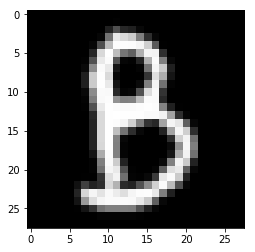

7


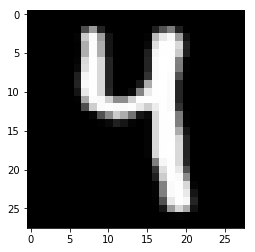

6


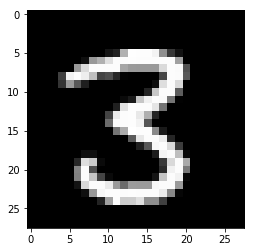

3


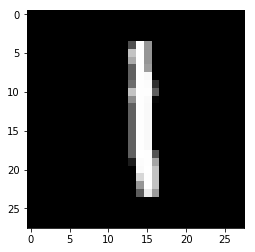

1


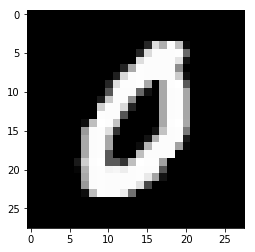

0


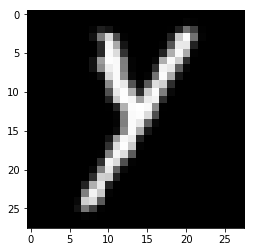

7


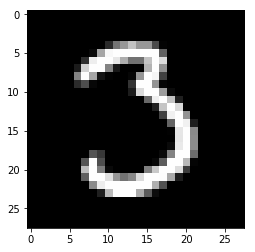

3


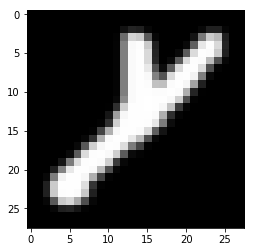

5


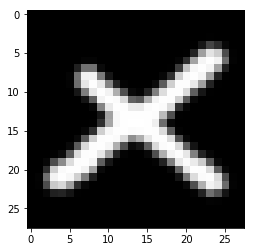

5


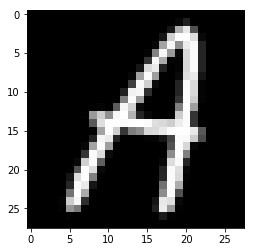

6


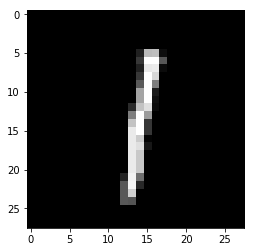

1


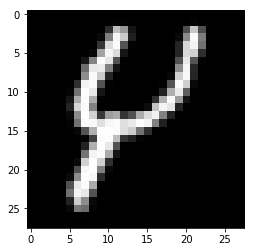

5


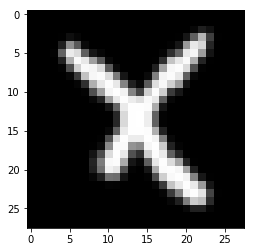

7


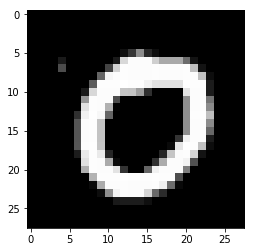

0


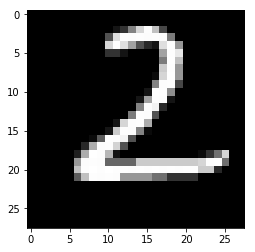

2


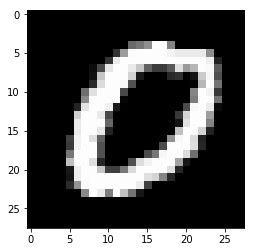

0


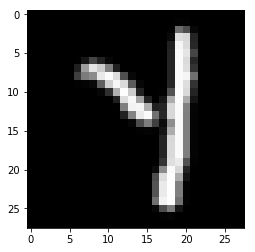

5


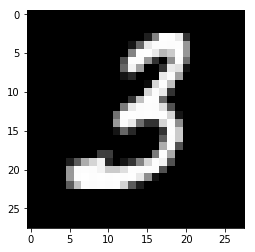

3


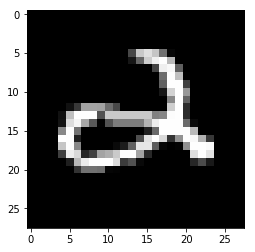

2


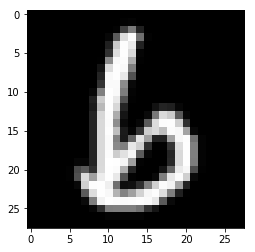

4


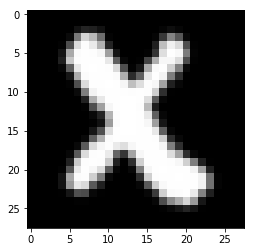

4


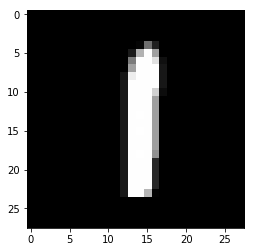

1


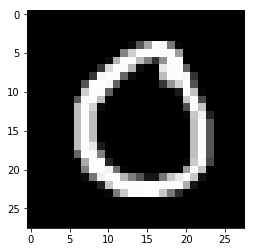

0


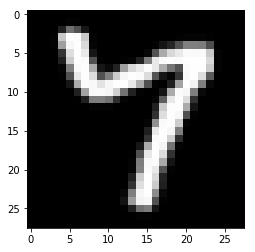

5


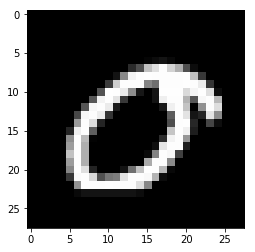

0


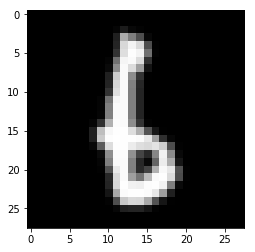

7


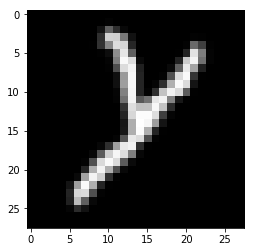

5


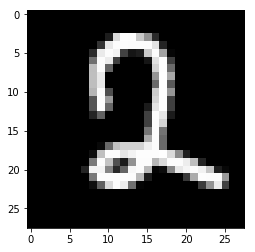

2


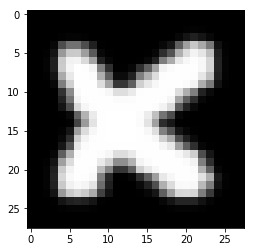

4


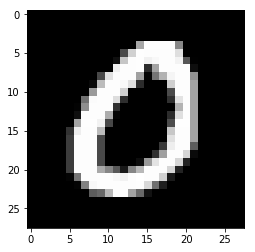

0


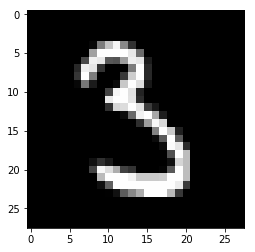

3


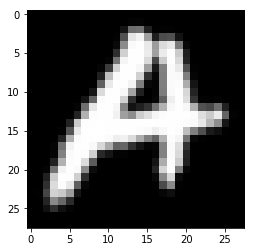

6


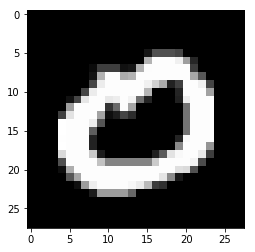

0


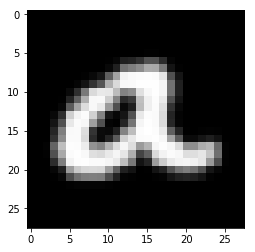

6


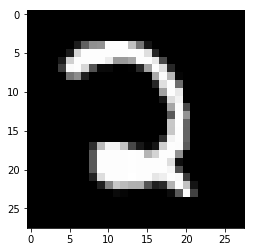

2


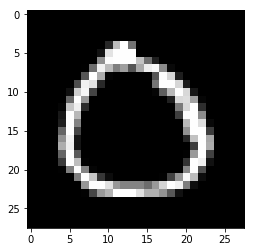

0


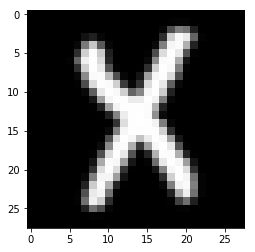

5


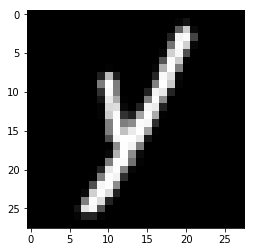

5


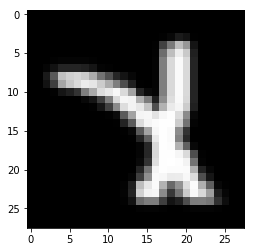

6


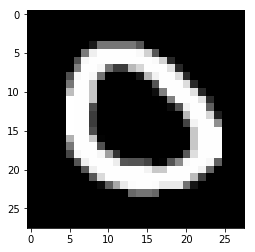

0


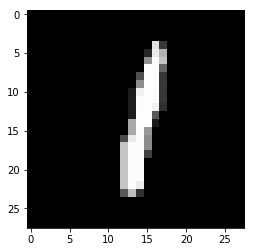

1


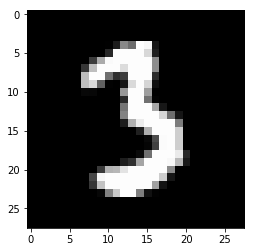

3


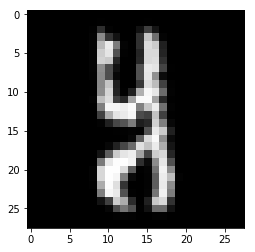

6


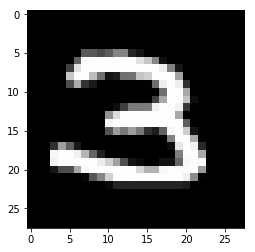

3


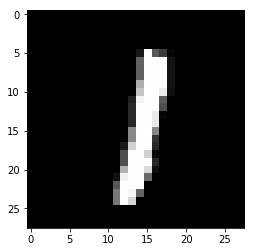

1


In [12]:
y_train = y_train.astype('int')
for i in range(100):
    show_image(X_train[i].reshape((28, 28)))
    print(y_train[i])

In [10]:
batch_size = 128
num_epochs = 20
hidden_size = 512

num_train = (letters_num + numbers_num) * class_num_train
num_test = (letters_num + numbers_num) * class_num_test

height, width, depth = 28, 28, 1
num_classes = letters_num + numbers_num


X_train = X_train.reshape(num_train, height * width)
X_test = X_test.reshape(num_test, height * width)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int')
y_test = y_test.astype('int')
X_train /= 255
X_test /= 255
X_train = X_train
X_test = X_test

X_train = X_train.reshape((X_train.shape[0], height, width, 1))
X_test = X_test.reshape((X_test.shape[0], height, width, 1))

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

inp = Input(shape=(height, width, 1))
out = inp
out = ZeroPadding2D()(out)
out = Conv2D(kernel_size=(3, 3), filters=16)(out)
out = LeakyReLU(alpha=0.1)(out)
out = MaxPooling2D()(out)
out = ZeroPadding2D()(out)
out = Conv2D(kernel_size=(3, 3), filters=32)(out)
out = LeakyReLU(alpha=0.1)(out)
out = MaxPooling2D()(out)
out = Flatten()(out)
out = Dense(512)(out)
out = LeakyReLU(alpha=0.1)(out)
out = Dense(num_classes, activation='softmax')(out)

model = Model(inp, out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy
model.summary()

model.fit(X_train, Y_train, 
          batch_size=batch_size, nb_epoch=num_epochs, verbose=1, validation_split=0.1, shuffle=False) # ...holding out 10% of the data for validation
model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
__________

[1.9478724559030065, 0.31593610698365526]

In [12]:
import h5py
model.save('Symbols_Fraiming/MixedModel8.h5')

In [8]:
batch_size = 128
num_epochs = 20
hidden_size = 512

num_train = (letters_num + numbers_num) * class_num_train
num_test = (letters_num + numbers_num) * class_num_test

height, width, depth = 28, 28, 1
num_classes = letters_num + numbers_num

#(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(num_train, height * width)
X_test = X_test.reshape(num_test, height * width)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
X_train = X_train
X_test = X_test

Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

inp = Input(shape=(height * width,))
hidden_1 = Dense(hidden_size, activation='relu')(inp)
hidden_2 = Dense(hidden_size, activation='relu')(hidden_1)
out = Dense(num_classes, activation='softmax')(hidden_2)

model = Model(inp, out)

model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
              optimizer='adam', # using the Adam optimiser
              metrics=['accuracy']) # reporting the accuracy

model.fit(X_train, Y_train, # Train the model using the training set...
          batch_size=batch_size, nb_epoch=num_epochs,
          verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!

Train on 43610 samples, validate on 4846 samples
Epoch 1/20
43610/43610 [==============================] - 3s 59us/step - loss: 1.0284 - acc: 0.6170 - val_loss: 2.0460 - val_acc: 0.3192
Epoch 2/20
43610/43610 [==============================] - 2s 50us/step - loss: 0.7601 - acc: 0.7185 - val_loss: 1.5197 - val_acc: 0.4280
Epoch 3/20
43610/43610 [==============================] - 2s 50us/step - loss: 0.5276 - acc: 0.8208 - val_loss: 1.0120 - val_acc: 0.6608
Epoch 4/20
43610/43610 [==============================] - 2s 50us/step - loss: 0.3719 - acc: 0.8786 - val_loss: 0.7839 - val_acc: 0.7460
Epoch 5/20
43610/43610 [==============================] - 2s 53us/step - loss: 0.2976 - acc: 0.9039 - val_loss: 0.6840 - val_acc: 0.7693
Epoch 6/20
43610/43610 [==============================] - 2s 53us/step - loss: 0.2508 - acc: 0.9183 - val_loss: 0.5794 - val_acc: 0.8157
Epoch 7/20
43610/43610 [==============================] - 2s 55us/step - loss: 0.2225 - acc: 0.9273 - val_loss: 0.5425 - val_acc:

[0.2775930386455651, 0.9366848274428242]

In [10]:
import h5py
model.save('Symbols_Fraiming/MixedModel5.h5')

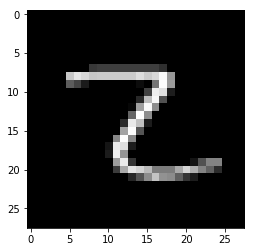

1


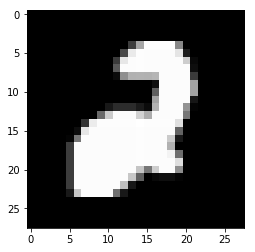

1


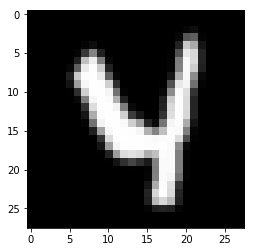

5


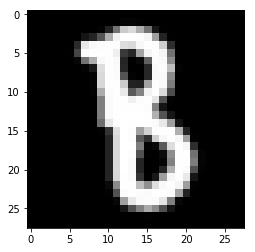

7


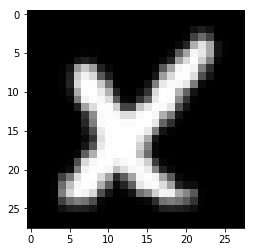

4


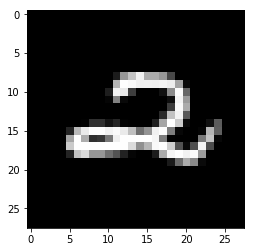

5


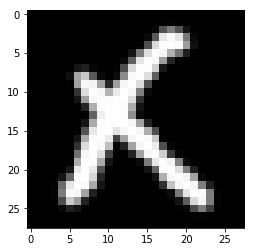

3


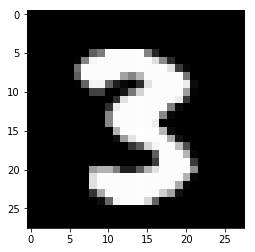

3


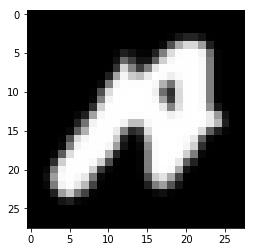

6


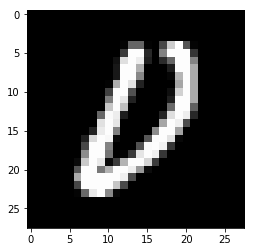

0


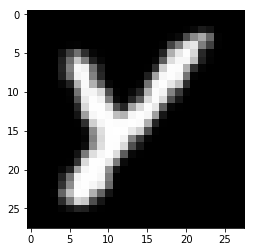

5


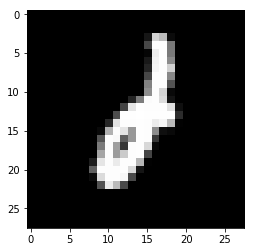

2


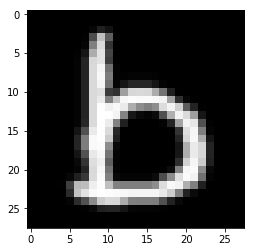

7


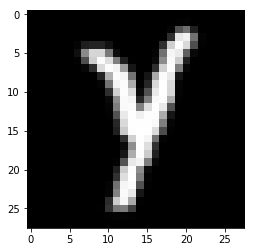

5


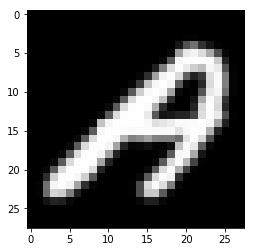

2


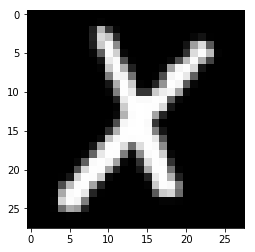

4


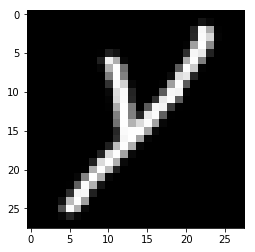

5


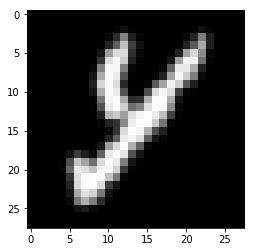

5


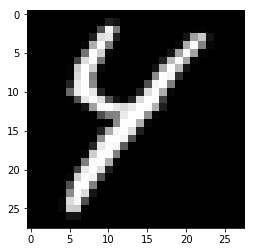

5


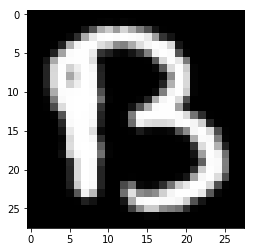

2


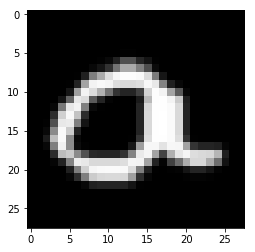

3


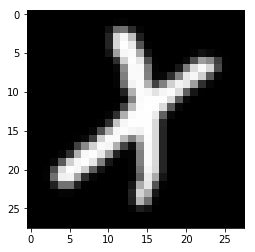

4


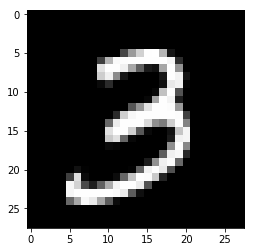

3


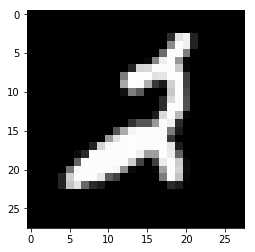

3


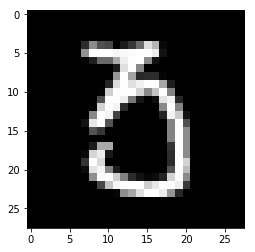

0


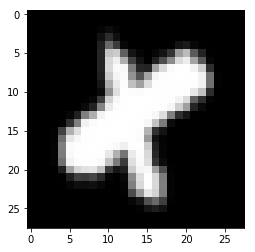

5


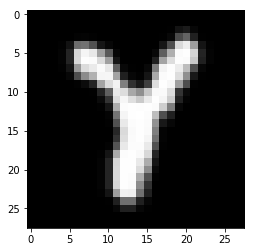

5


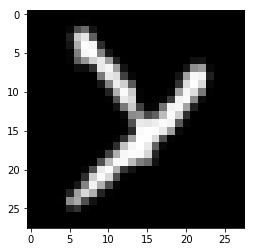

5


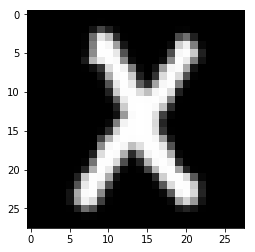

4


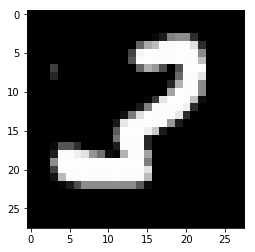

0


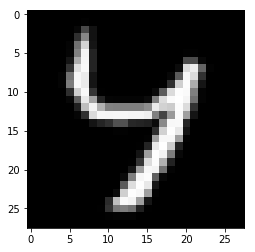

5


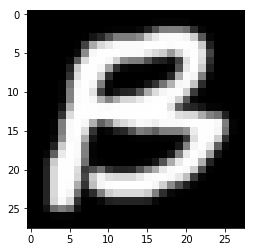

7


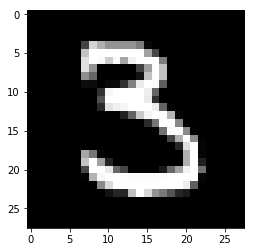

6


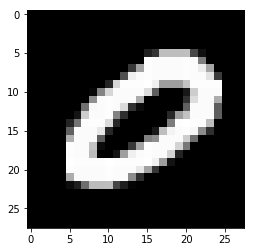

4


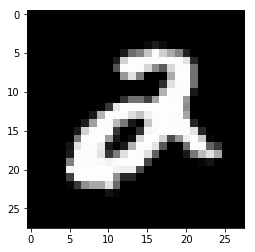

2


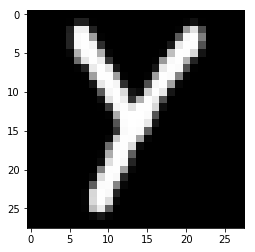

5


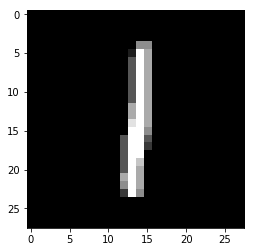

7


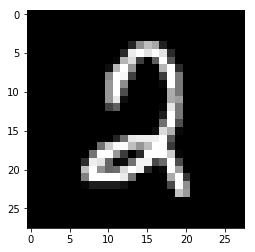

2


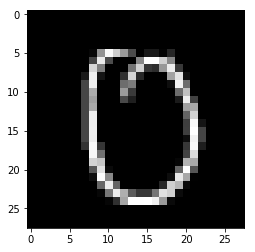

4


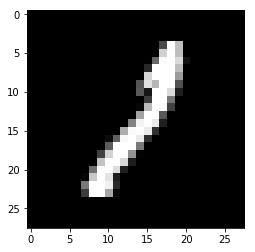

1


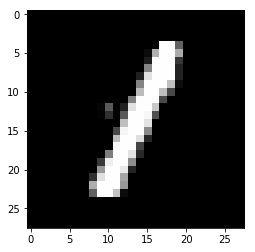

1


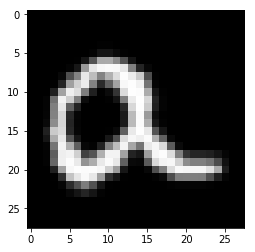

6


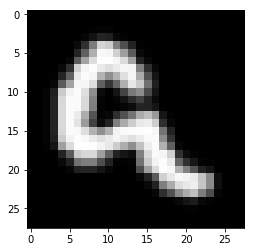

6


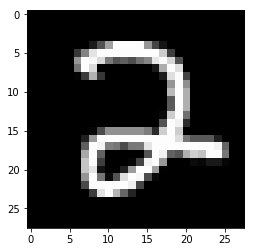

6


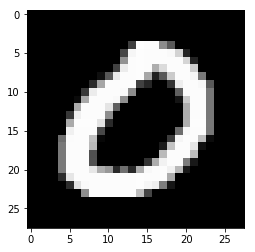

0


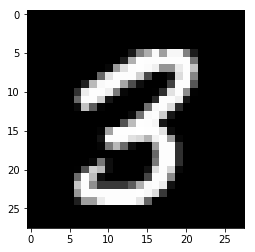

3


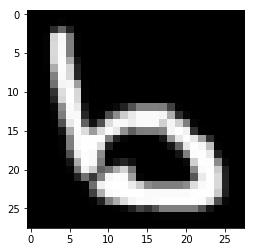

7


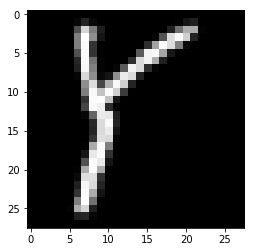

5


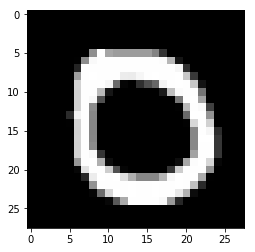

1


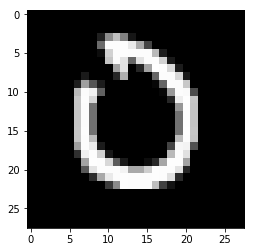

0


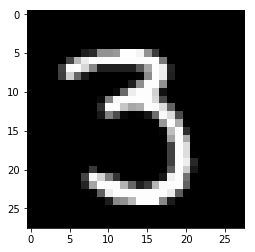

6


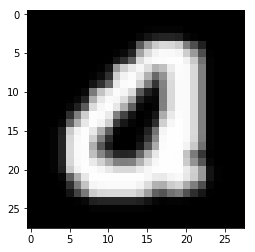

6


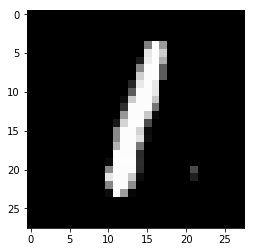

5


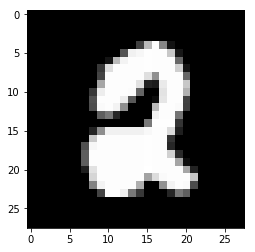

2


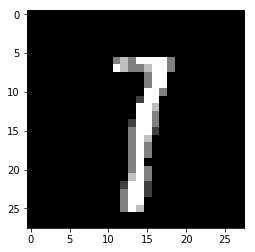

0


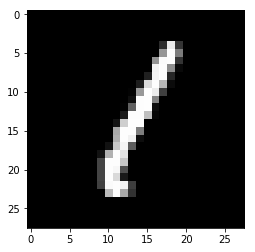

0


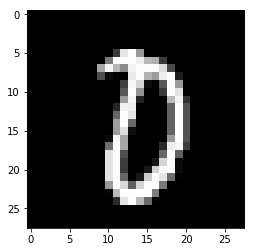

6


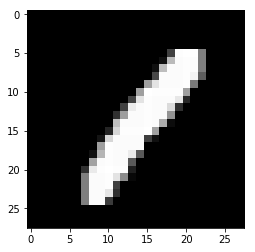

1


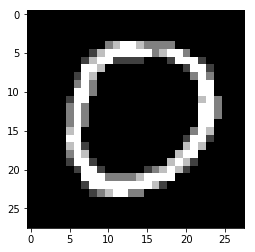

0


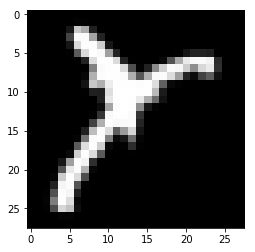

5


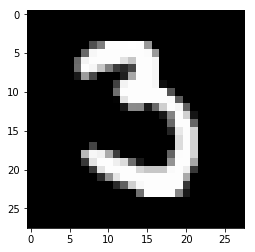

5


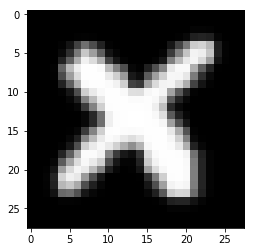

4


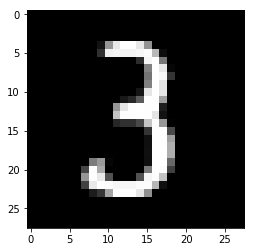

3


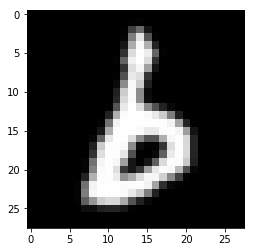

7


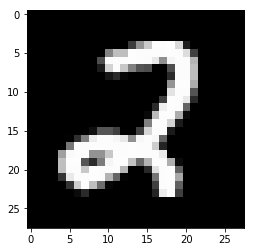

2


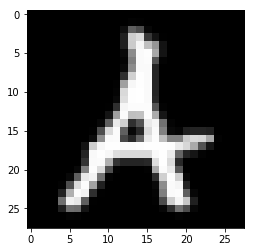

3


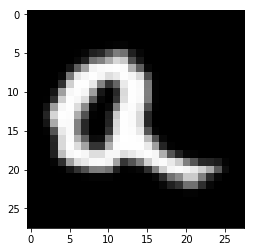

6


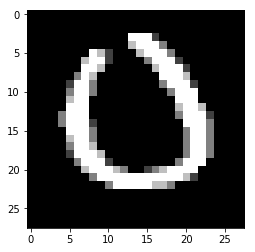

0


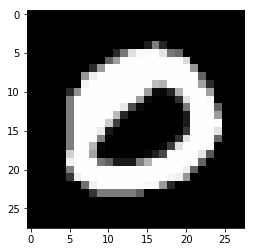

4


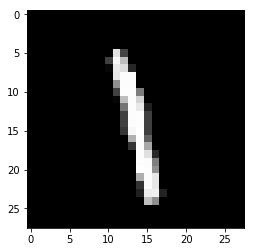

1


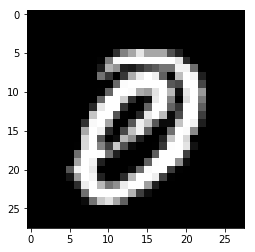

2


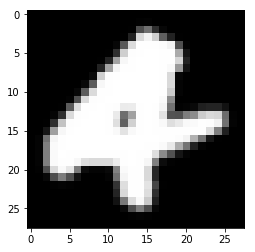

7


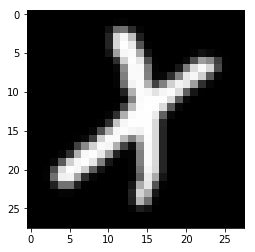

4


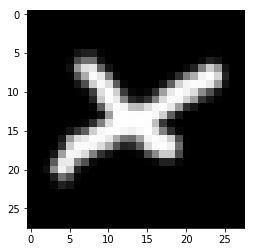

4


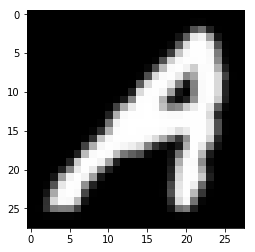

2


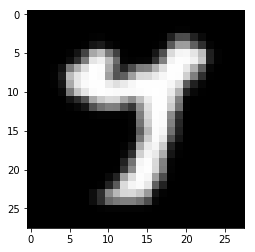

5


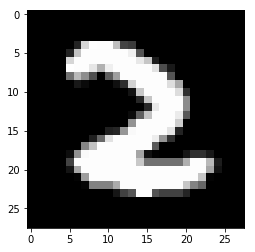

7


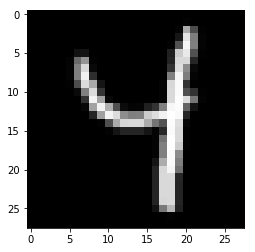

5


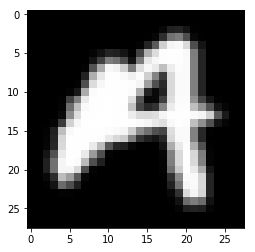

5


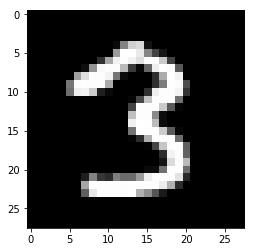

2


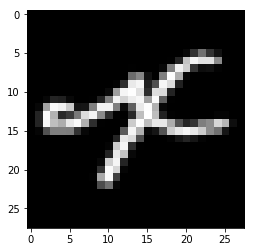

6


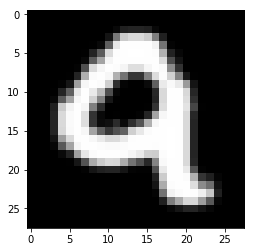

1


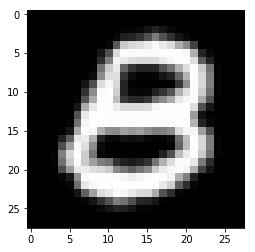

7


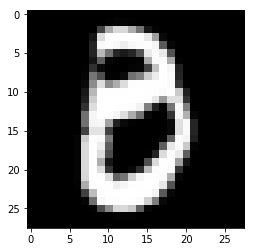

7


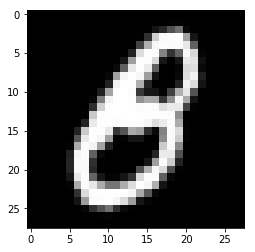

7


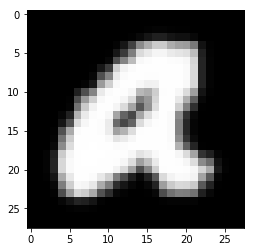

6


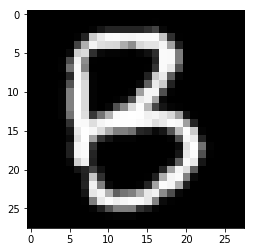

4


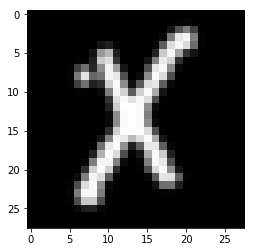

4


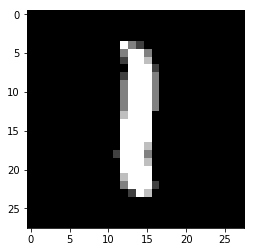

2


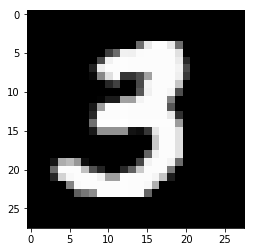

0


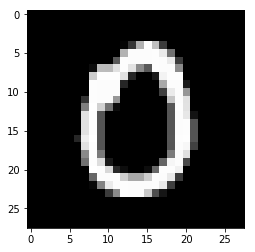

3


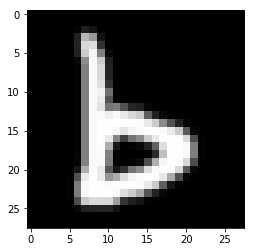

7


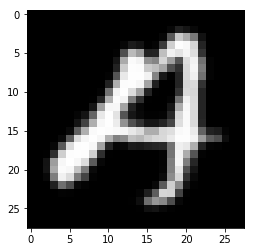

6


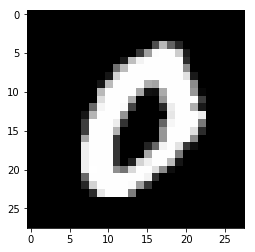

4


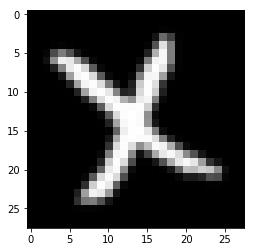

4


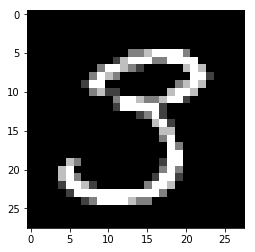

5


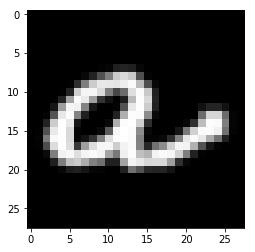

6


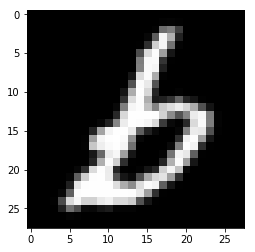

7


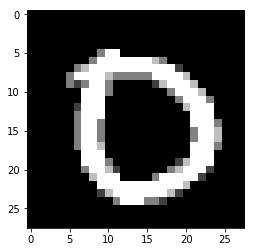

2


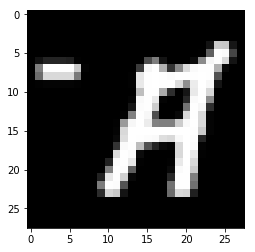

6


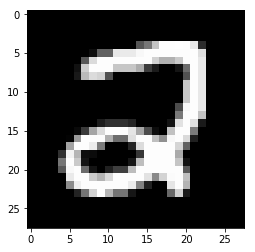

2


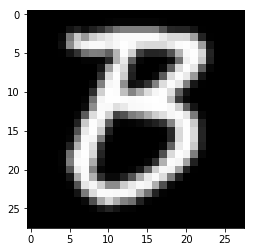

2


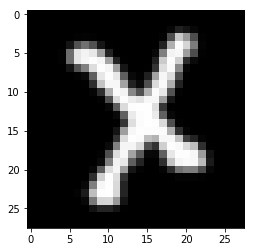

4


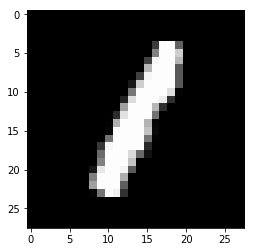

1


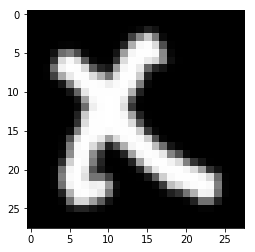

5


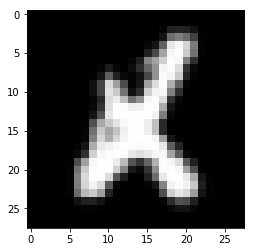

2


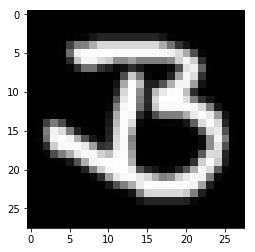

7


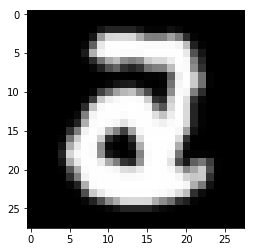

2


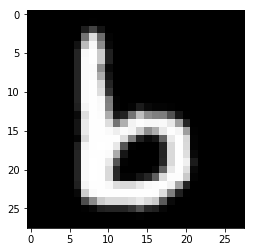

7


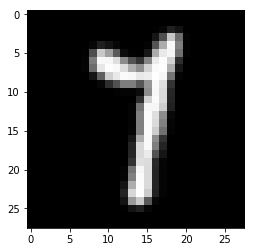

5


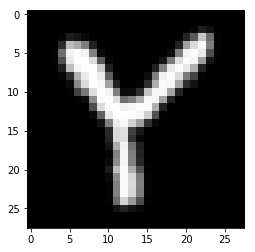

5


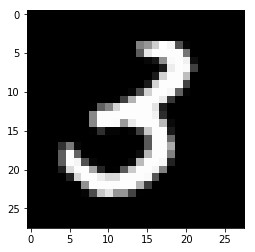

0


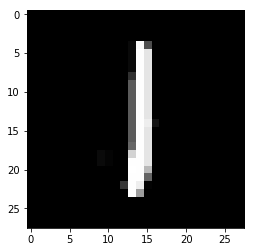

7


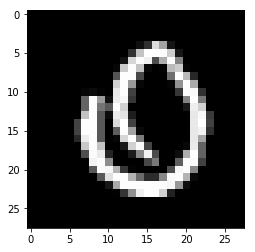

0


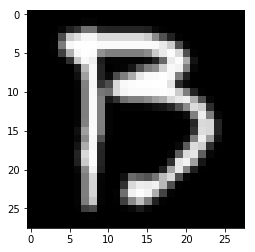

7


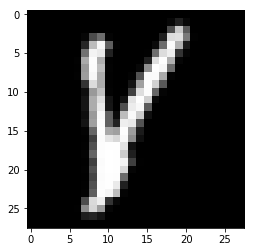

4


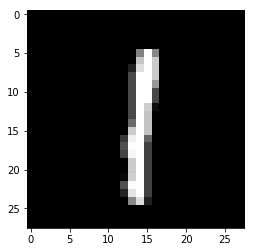

3


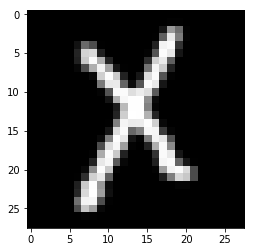

2


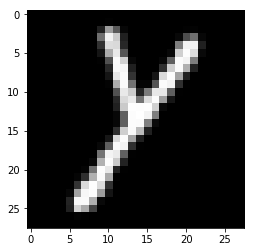

3


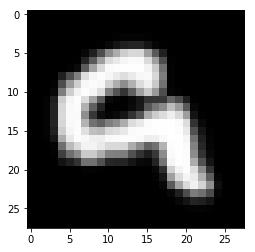

6


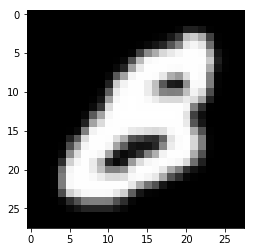

7


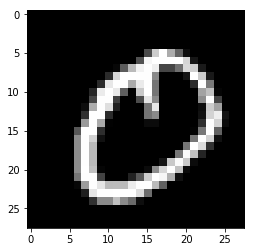

2


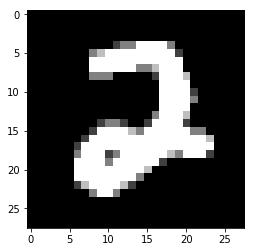

2


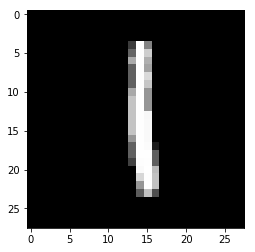

7


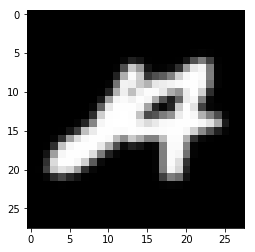

0


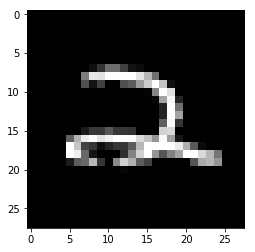

1


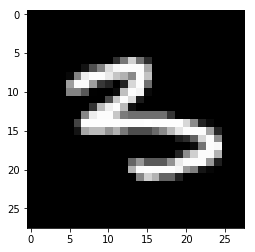

4


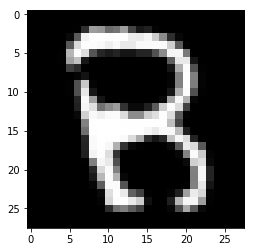

2


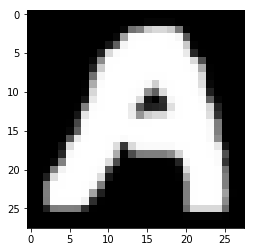

1


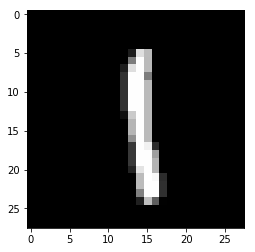

0


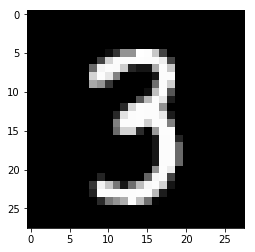

1


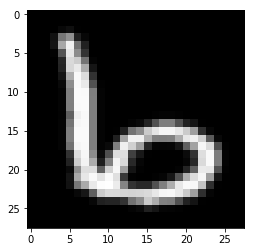

3


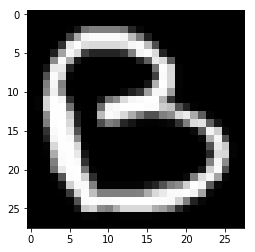

1


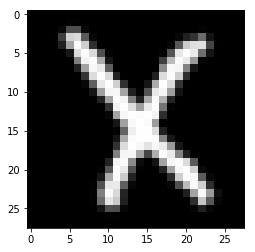

4


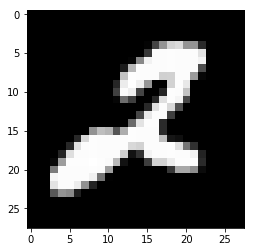

3


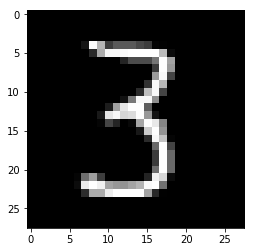

4


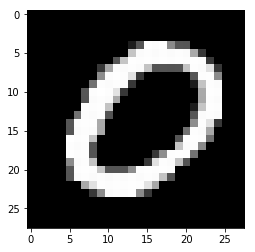

0


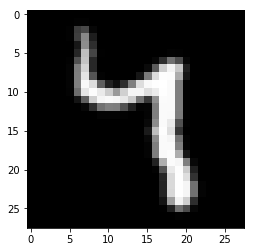

5


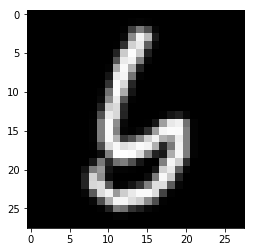

3


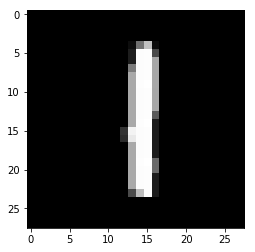

1


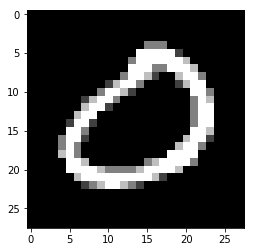

0


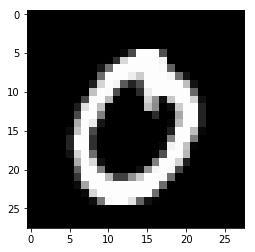

2


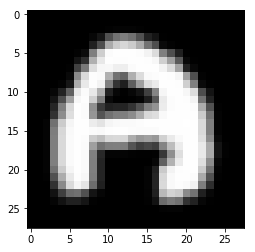

0


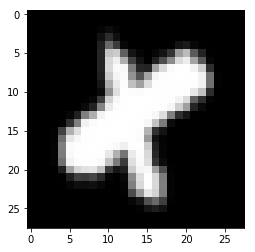

5


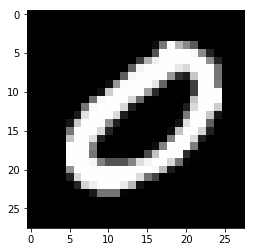

0


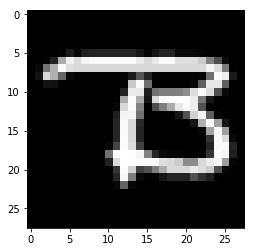

7


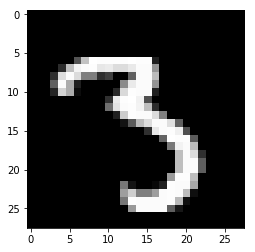

3


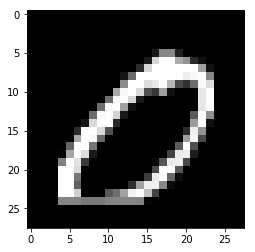

0


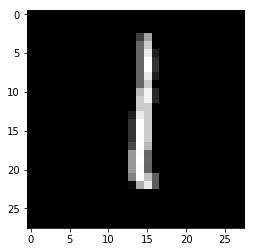

4


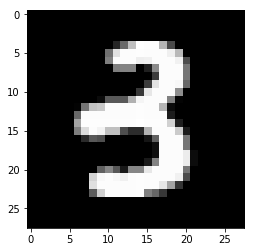

5


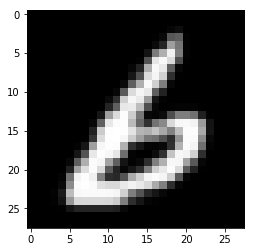

7


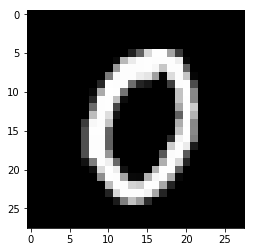

2


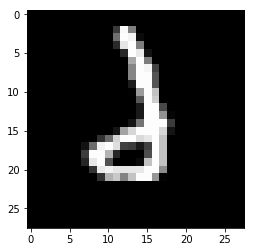

1


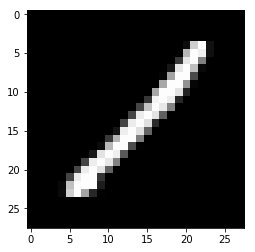

1


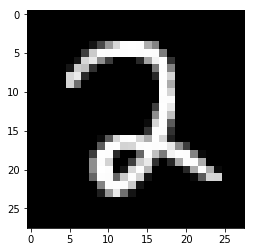

2


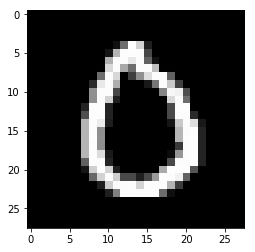

0


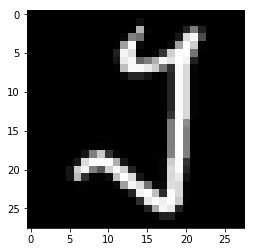

1


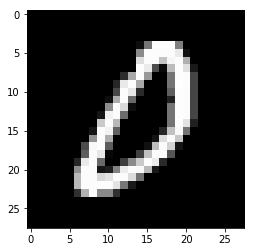

2


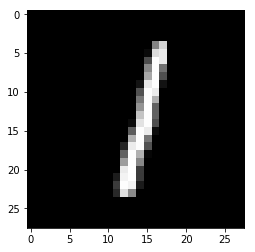

2


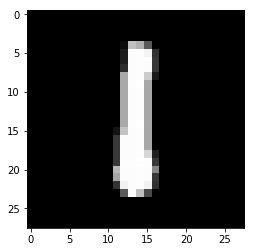

7


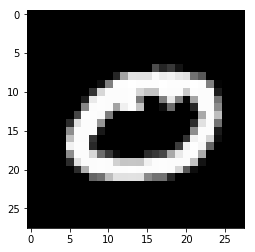

0


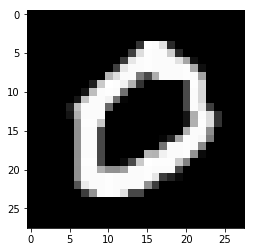

6


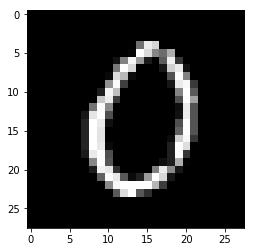

7


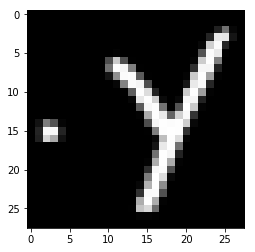

5


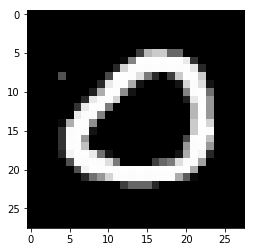

2


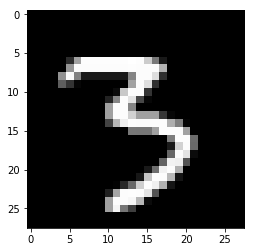

2


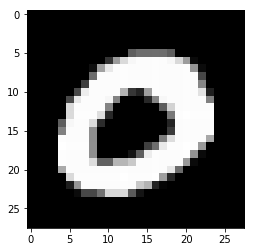

0


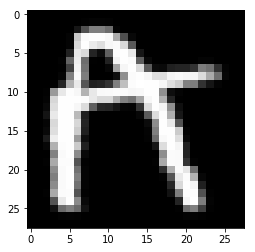

6


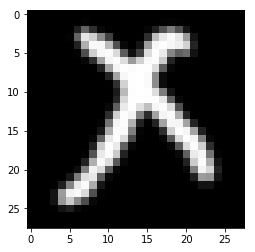

4


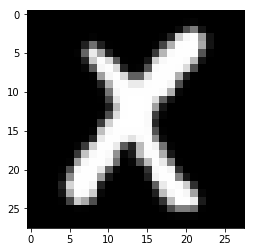

4


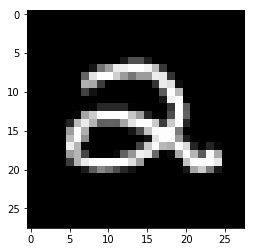

1


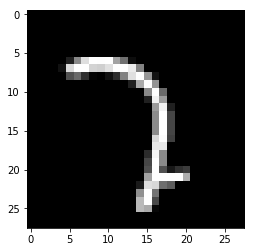

1


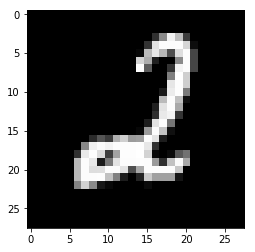

6


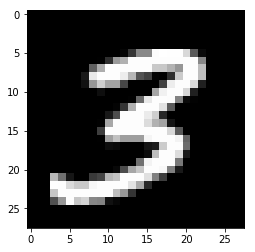

0


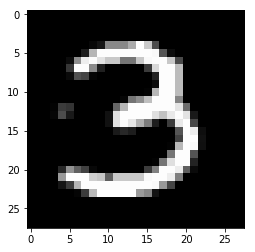

6


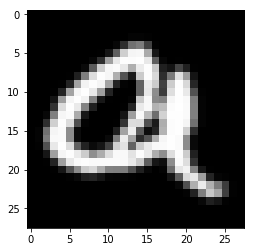

6


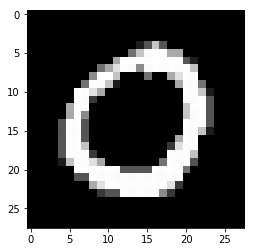

1


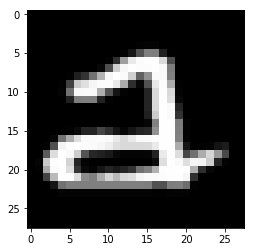

1


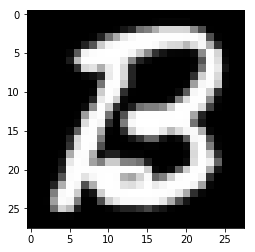

7


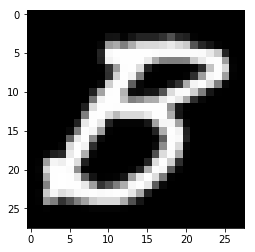

1


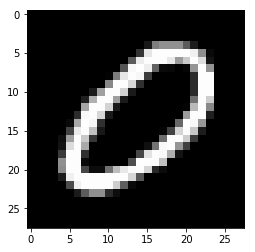

0


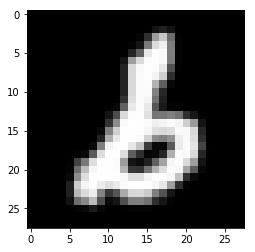

7


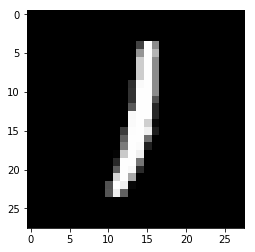

1


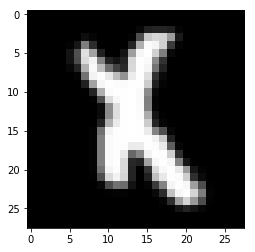

4


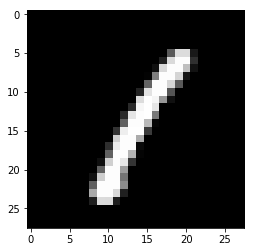

6


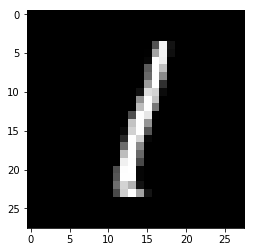

5


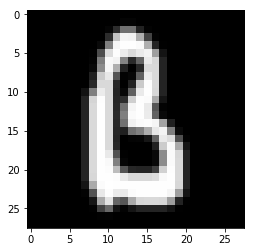

7


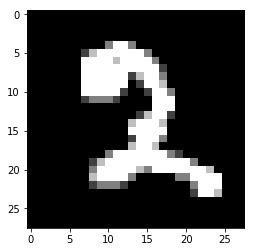

1


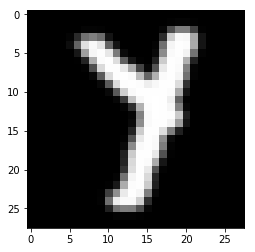

5


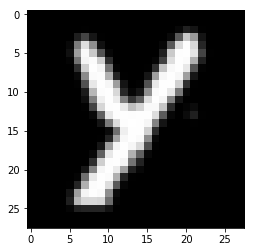

5


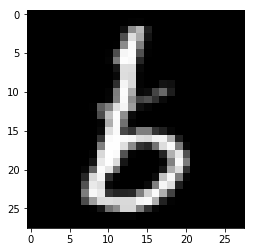

7


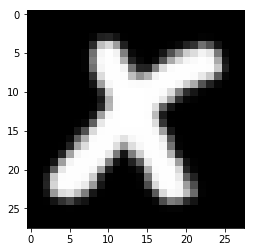

4


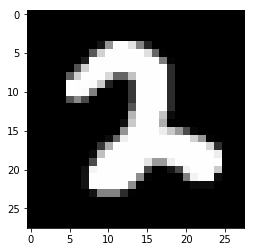

0


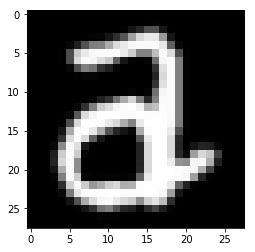

7


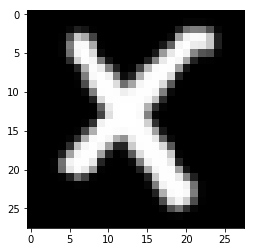

4


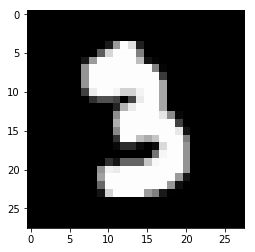

3


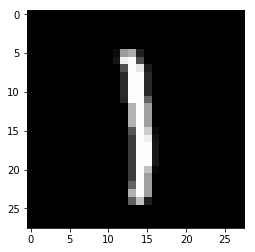

0


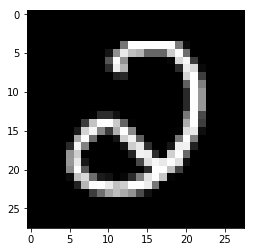

2


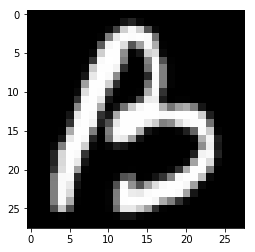

7


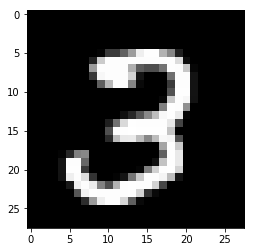

3


In [11]:
def pred(image, model):
    number = -1;
    maximum = -1
    prediction = model.predict(image.reshape((1, 28, 28, 1)))
    for i in range(len(prediction[0])):
        if (prediction[0][i] > maximum):
            maximum = prediction[0][i]
            number = i
    return number

for i in range(200):
    show_image(X_train[i].reshape(28, 28))
    print(pred(X_train[i], model));